<a href="https://colab.research.google.com/github/stranger9977/market_implied_fantasy_football/blob/main/playerpropprojections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import pandas as pd
import re
import nfl_data_py as nfl
from IPython.display import display, HTML
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from datetime import datetime
from dotenv import load_dotenv
import os

load_dotenv()
api_key = os.getenv("API_KEY")

In [31]:
api_key


'554d1e6028cada8b9a8e0ec139fde16a'

In [32]:


# Get the current time in ISO8601 format
current_time_iso = datetime.utcnow().strftime("%Y-%m-%dT%H:%M:%SZ")

# Your API key
api_key = api_key

# Regions and Markets
regions = ["us",'us2']
# check this out for avaialble markets https://the-odds-api.com/sports-odds-data/betting-markets.html
markets = [    'player_anytime_td',
    'player_pass_completions',
    'player_pass_interceptions',
    'player_pass_tds',
    'player_pass_yds',
    'player_reception_yds',
    'player_receptions',
    'player_rush_yds']

format = "american"

# Convert list to comma-separated string
regions_str = ",".join(regions)
markets_str = ",".join(markets)

# Date range for filtering events (for the current time)
commence_time_from = current_time_iso
commence_time_to = current_time_iso

# Step 1: Fetch event IDs
url_events = f"https://api.the-odds-api.com/v4/sports/americanfootball_nfl/events/?apiKey={api_key}&regions={regions_str}&commenceTimeFrom={commence_time_from}&commenceTimeTo={commence_time_to}&oddsFormat={format}"
response_events = requests.get(url_events)
events_data = response_events.json()

# Extract event IDs
event_ids = [event['id'] for event in events_data]

# Initialize an empty list to store the fetched data
fetched_data = []

# Fetch odds for each event ID
for event_id in event_ids:
    url_odds = f"https://api.the-odds-api.com/v4/sports/americanfootball_nfl/events/{event_id}/odds/?apiKey={api_key}&regions={regions_str}&markets={markets_str}&oddsFormat={format}"
    response_odds = requests.get(url_odds)
    odds_data = response_odds.json()

    # Store the fetched data along with the event_id
    fetched_data.append({'event_id': event_id, 'odds_data': odds_data})


In [33]:
print(fetched_data[0:1])

[{'event_id': '934acd8d5f569c955f4a02aa42284fa4', 'odds_data': {'id': '934acd8d5f569c955f4a02aa42284fa4', 'sport_key': 'americanfootball_nfl', 'sport_title': 'NFL', 'commence_time': '2023-09-29T00:15:00Z', 'home_team': 'Green Bay Packers', 'away_team': 'Detroit Lions', 'bookmakers': [{'key': 'fanduel', 'title': 'FanDuel', 'markets': [{'key': 'player_anytime_td', 'last_update': '2023-09-27T16:38:24Z', 'outcomes': [{'name': 'Yes', 'description': 'AJ Dillon', 'price': 110}, {'name': 'Yes', 'description': 'Jahmyr Gibbs', 'price': 125}, {'name': 'Yes', 'description': 'Aaron Jones', 'price': 125}, {'name': 'Yes', 'description': 'Amon-Ra St. Brown', 'price': 140}, {'name': 'Yes', 'description': 'David Montgomery', 'price': 145}, {'name': 'Yes', 'description': 'Christian Watson', 'price': 230}, {'name': 'Yes', 'description': 'Romeo Doubs', 'price': 230}, {'name': 'Yes', 'description': 'Sam LaPorta', 'price': 250}, {'name': 'Yes', 'description': 'Luke Musgrave', 'price': 290}, {'name': 'Yes', '

In [34]:
import pandas as pd

# Initialize an empty DataFrame
odds_df = pd.DataFrame()

# Iterate through the fetched data
for data in fetched_data:
    event_id = data['event_id']
    odds_data = data['odds_data']

    # Convert JSON to DataFrame
    temp_df = pd.json_normalize(odds_data, sep='_')

    # Add event_id as a level of multi-index
    temp_df['game_id'] = event_id

    # Extract bookmakers data into separate DataFrame and merge
    for bookmaker in odds_data['bookmakers']:
      if isinstance(bookmaker, dict):
          for market in bookmaker['markets']:
              bookmaker_df = pd.json_normalize(market['outcomes'], sep='_')
              bookmaker_df['bookmaker'] = bookmaker['key']
              bookmaker_df['last_update'] = market['last_update']
              bookmaker_df['market'] = market['key']

              # Check if 'point' exists and include it
              points = [outcome.get('point', None) for outcome in market['outcomes']]
              bookmaker_df['point'] = points

              # Concatenate with other relevant columns
              bookmaker_df = pd.concat([temp_df[['game_id', 'commence_time', 'home_team', 'away_team']], bookmaker_df], axis=1)

              # Append to the final DataFrame
              odds_df = pd.concat([odds_df, bookmaker_df])

# Convert 'price' and 'point' columns to numeric
odds_df['price'] = pd.to_numeric(odds_df['price'], errors='coerce')
odds_df['point'] = pd.to_numeric(odds_df['point'], errors='coerce')

# Forward fill the NaN values for these columns
odds_df[['game_id', 'commence_time', 'home_team', 'away_team']] = odds_df[['game_id', 'commence_time', 'home_team', 'away_team']].fillna(method='ffill')

# Display DataFrame info
odds_df.info(verbose=True)




<class 'pandas.core.frame.DataFrame'>
Int64Index: 1684 entries, 0 to 1
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   game_id        1684 non-null   object 
 1   commence_time  1684 non-null   object 
 2   home_team      1684 non-null   object 
 3   away_team      1684 non-null   object 
 4   name           1684 non-null   object 
 5   description    1684 non-null   object 
 6   price          1684 non-null   int64  
 7   bookmaker      1684 non-null   object 
 8   last_update    1684 non-null   object 
 9   market         1684 non-null   object 
 10  point          745 non-null    float64
dtypes: float64(1), int64(1), object(9)
memory usage: 157.9+ KB


In [98]:
odds_df.rename(columns ={'labeL':'label'},inplace=True)

In [99]:
# TO DO ..
# Get Historical Player Prop odds?
# import requests
# from datetime import datetime

# # Specify the date for which you want to fetch data (September 8th, 2022)
# specified_date = "2023-09-08T11:00:00Z"

# # Your API key
# api_key = "554d1e6028cada8b9a8e0ec139fde16a"

# # Regions and Markets
# regions = ["us"]
# markets = ['player_anytime_td']  # One market for this example

# # Convert list to comma-separated string
# regions_str = ",".join(regions)
# markets_str = ",".join(markets)

# # Step 1: Fetch event IDs
# url_events = f"https://api.the-odds-api.com/v4/sports/americanfootball_nfl/odds-history/?apiKey={api_key}&regions={regions_str}&date={specified_date}"
# response_events = requests.get(url_events)
# events_data = response_events.json()

# # Check if 'data' key exists in the dictionary
# if 'data' in events_data:
#     # Extract event IDs
#     event_ids = [event['id'] for event in events_data['data']]
# else:
#     print("No 'data' key found in the response.")
#     event_ids = []

# # Step 2: Fetch odds for each event ID using the new endpoint
# for event_id in event_ids:
#     url_odds = f"https://api.the-odds-api.com/v4/sports/americanfootball_nfl/events/{event_id}/odds/?apiKey={api_key}&regions={regions_str}&markets={markets_str}&dateFormat=iso&oddsFormat=decimal"
#     response_odds = requests.get(url_odds)
#     odds_data = response_odds.json()
#     print(f"Odds for event ID {event_id}: {odds_data}")


In [100]:

# Assuming df is your DataFrame
# Define the list of markets you want to keep
markets_to_keep = [
    'player_anytime_td',
    'player_pass_completions',
    'player_pass_interceptions',
    'player_pass_tds',
    'player_pass_yds',
    'player_reception_yds',
    'player_receptions',
    'player_rush_yds'
]

# Filter the DataFrame to only include rows with the specified markets
odds_df = odds_df[odds_df['market'].isin(markets_to_keep)]



In [101]:
odds_df.columns

Index(['game_id', 'commence_time', 'home_team', 'away_team', 'label',
       'description', 'price', 'bookmaker', 'last_update', 'market', 'point',
       'group_by_name', 'implied_probability'],
      dtype='object')

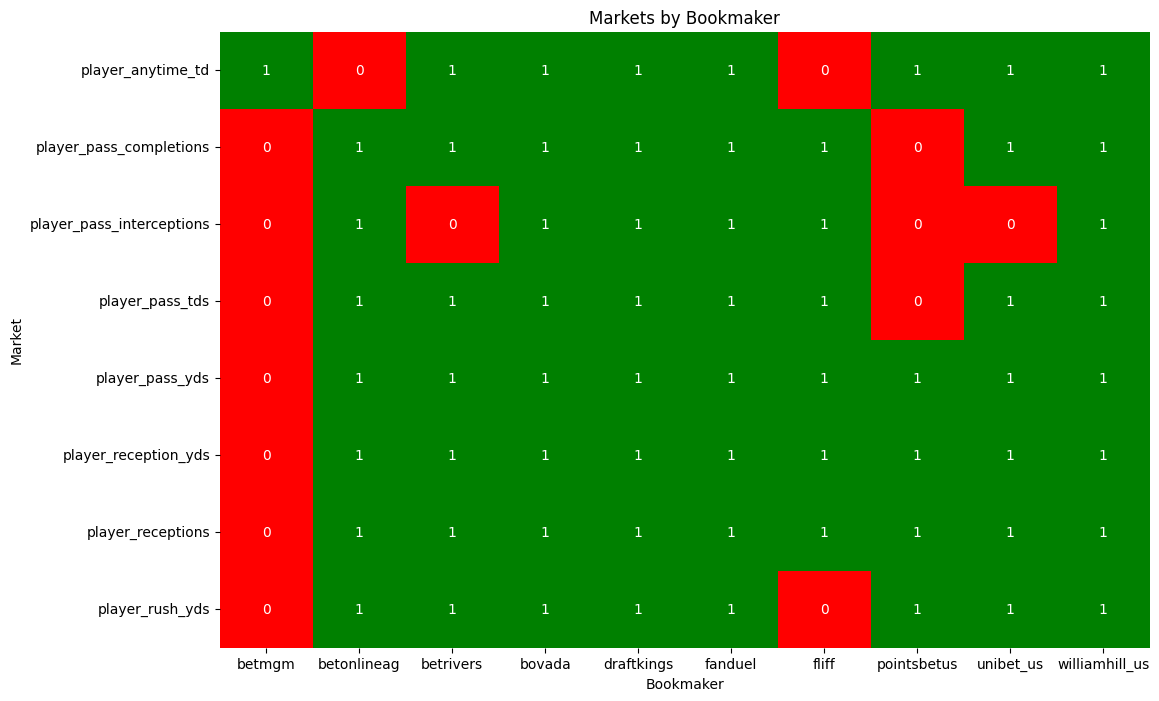

In [102]:
# Filter the DataFrame to only include rows with the specified markets
df_filtered = odds_df

# Drop bookmakers that don't have any of these markets
bookmakers_to_drop = df_filtered.groupby('bookmaker').filter(lambda x: len(set(x['market']) & set(markets_to_keep)) == 0)['bookmaker'].unique()
df_filtered = df_filtered[~df_filtered['bookmaker'].isin(bookmakers_to_drop)]

# Create a pivot table to visualize which bookmakers have which markets
pivot_df = pd.crosstab(df_filtered['market'], df_filtered['bookmaker'])

# Replace non-zero values with green and zero values with red
pivot_df = pivot_df.applymap(lambda x: 'green' if x > 0 else 'red')

# Plot the grid
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df.applymap(lambda x: 1 if x == 'green' else 0), annot=True, cbar=False, cmap=["red", "green"], xticklabels=pivot_df.columns, yticklabels=pivot_df.index)
plt.xlabel('Bookmaker')
plt.ylabel('Market')
plt.title('Markets by Bookmaker')
plt.show()


In [103]:
# Drop rows where bookmaker is 'Barstool Sportsbook'
odds_df = odds_df[odds_df['bookmaker'] != 'barstool']

# Now you can proceed with the rest of the analysis
df = odds_df

In [104]:
price_range_df = df.groupby('market')['price'].agg(['min', 'max']).reset_index()
price_range_df

,market,min,max
0,player_anytime_td,-255,15000
1,player_pass_completions,-136,104
2,player_pass_interceptions,-175,130
3,player_pass_tds,-300,215
4,player_pass_yds,-160,120
5,player_reception_yds,-145,110
6,player_receptions,-185,135
7,player_rush_yds,-150,115


In [105]:
# Function to get min and max for price and point along with corresponding description
def get_min_max(df, market):
    min_price_row = df[df['market'] == market].nsmallest(1, 'price')
    max_price_row = df[df['market'] == market].nlargest(1, 'price')
    min_point_row = df[df['market'] == market].nsmallest(1, 'point')
    max_point_row = df[df['market'] == market].nlargest(1, 'point')

    return {
        'market': market,
        'min_price': min_price_row['price'].values[0],
        'min_price_desc': min_price_row['description'].values[0],
        'max_price': max_price_row['price'].values[0],
        'max_price_desc': max_price_row['description'].values[0],
        'min_point': min_point_row['point'].values[0],
        'min_point_desc': min_point_row['description'].values[0],
        'max_point': max_point_row['point'].values[0],
        'max_point_desc': max_point_row['description'].values[0]
    }

# Get unique markets
unique_markets = df['market'].unique()

# Get min and max for each market
min_max_list = [get_min_max(df, market) for market in unique_markets]

# Create DataFrame
min_max_df = pd.DataFrame(min_max_list)

print(min_max_df)


                      market  min_price       min_price_desc  max_price  \
0          player_anytime_td       -255  Christian McCaffrey      15000   
1    player_pass_completions       -136          Jordan Love        104   
2  player_pass_interceptions       -175       Tua Tagovailoa        130   
3            player_pass_tds       -300        Justin Fields        215   
4            player_pass_yds       -160           Jared Goff        120   
5       player_reception_yds       -145          Dawson Knox        110   
6          player_receptions       -185           Gabe Davis        135   
7            player_rush_yds       -150       Raheem Mostert        115   

   max_price_desc  min_point    min_point_desc  max_point    max_point_desc  
0  Brandon Graham        NaN         AJ Dillon        NaN         AJ Dillon  
1     Jordan Love       18.5    Desmond Ridder       23.5        Jared Goff  
2  Tua Tagovailoa        0.5       Jordan Love        0.5       Jordan Love  
3   Justin F

In [106]:
# Group by 'market' and calculate the standard deviation for 'adjusted_point'
std_deviation_by_market = df.groupby('market')['point'].mean()

# Display the standard deviation for each market
print(std_deviation_by_market)


market
player_anytime_td                   NaN
player_pass_completions       21.600000
player_pass_interceptions      0.500000
player_pass_tds                1.425234
player_pass_yds              245.295455
player_reception_yds          46.412088
player_receptions              4.166667
player_rush_yds               38.916667
Name: point, dtype: float64


In [107]:
# Assuming df is your DataFrame
unique_markets = df['market'].unique()

# Display the unique markets
print("Unique Markets:")
for market in unique_markets:
    print(market)


Unique Markets:
player_anytime_td
player_pass_completions
player_pass_interceptions
player_pass_tds
player_pass_yds
player_reception_yds
player_receptions
player_rush_yds


In [108]:
import re

def preprocess_name(name):
    name = name.lower()  # Convert to lowercase
    name = re.sub(r'(jr\.|sr\.|ii|iii|iv|v)$', '', name)  # Remove suffixes at the end
    name = re.sub(r'\W+', '', name)  # Remove non-alphanumeric characters
    return name



    return cleaned_name

# Apply the function to the 'description' column
df['group_by_name'] = df['description'].apply(preprocess_name)




In [109]:
df

,game_id,commence_time,home_team,away_team,label,description,price,bookmaker,last_update,market,point,group_by_name,implied_probability
0,934acd8d5f569c955f4a02aa42284fa4,2023-09-29T00:15:00Z,Green Bay Packers,Detroit Lions,Yes,AJ Dillon,110,fanduel,2023-09-27T16:38:24Z,player_anytime_td,NaN,ajdillon,0.476190
1,934acd8d5f569c955f4a02aa42284fa4,2023-09-29T00:15:00Z,Green Bay Packers,Detroit Lions,Yes,Jahmyr Gibbs,125,fanduel,2023-09-27T16:38:24Z,player_anytime_td,NaN,jahmyrgibbs,0.444444
2,934acd8d5f569c955f4a02aa42284fa4,2023-09-29T00:15:00Z,Green Bay Packers,Detroit Lions,Yes,Aaron Jones,125,fanduel,2023-09-27T16:38:24Z,player_anytime_td,NaN,aaronjones,0.444444
3,934acd8d5f569c955f4a02aa42284fa4,2023-09-29T00:15:00Z,Green Bay Packers,Detroit Lions,Yes,Amon-Ra St. Brown,140,fanduel,2023-09-27T16:38:24Z,player_anytime_td,NaN,amonrastbrown,0.416667
4,934acd8d5f569c955f4a02aa42284fa4,2023-09-29T00:15:00Z,Green Bay Packers,Detroit Lions,Yes,David Montgomery,145,fanduel,2023-09-27T16:38:24Z,player_anytime_td,NaN,davidmontgomery,0.408163
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,19b8f1eaf555f3eef3ce87a61ad7ad16,2023-10-01T20:25:00Z,Dallas Cowboys,New England Patriots,Over,Dak Prescott,-120,fliff,2023-09-27T16:39:42Z,player_pass_yds,233.5,dakprescott,0.545455
2,19b8f1eaf555f3eef3ce87a61ad7ad16,2023-10-01T20:25:00Z,Dallas Cowboys,New England Patriots,Under,Mac Jones,-120,fliff,2023-09-27T16:39:42Z,player_pass_yds,215.5,macjones,0.545455
3,19b8f1eaf555f3eef3ce87a61ad7ad16,2023-10-01T20:25:00Z,Dallas Cowboys,New England Patriots,Over,Mac Jones,-120,fliff,2023-09-27T16:39:42Z,player_pass_yds,215.5,macjones,0.545455
0,19b8f1eaf555f3eef3ce87a61ad7ad16,2023-10-01T20:25:00Z,Dallas Cowboys,New England Patriots,Under,CeeDee Lamb,-120,fliff,2023-09-27T16:39:42Z,player_reception_yds,69.5,ceedeelamb,0.545455


In [110]:
def calculate_implied_probability(price):
    if price > 0:
        return 100 / (price + 100)
    else:
        return abs(price) / (abs(price) + 100)

# Apply the function to the DataFrame
df['implied_probability'] = df['price'].apply(calculate_implied_probability)



In [111]:
df

,game_id,commence_time,home_team,away_team,label,description,price,bookmaker,last_update,market,point,group_by_name,implied_probability
0,934acd8d5f569c955f4a02aa42284fa4,2023-09-29T00:15:00Z,Green Bay Packers,Detroit Lions,Yes,AJ Dillon,110,fanduel,2023-09-27T16:38:24Z,player_anytime_td,NaN,ajdillon,0.476190
1,934acd8d5f569c955f4a02aa42284fa4,2023-09-29T00:15:00Z,Green Bay Packers,Detroit Lions,Yes,Jahmyr Gibbs,125,fanduel,2023-09-27T16:38:24Z,player_anytime_td,NaN,jahmyrgibbs,0.444444
2,934acd8d5f569c955f4a02aa42284fa4,2023-09-29T00:15:00Z,Green Bay Packers,Detroit Lions,Yes,Aaron Jones,125,fanduel,2023-09-27T16:38:24Z,player_anytime_td,NaN,aaronjones,0.444444
3,934acd8d5f569c955f4a02aa42284fa4,2023-09-29T00:15:00Z,Green Bay Packers,Detroit Lions,Yes,Amon-Ra St. Brown,140,fanduel,2023-09-27T16:38:24Z,player_anytime_td,NaN,amonrastbrown,0.416667
4,934acd8d5f569c955f4a02aa42284fa4,2023-09-29T00:15:00Z,Green Bay Packers,Detroit Lions,Yes,David Montgomery,145,fanduel,2023-09-27T16:38:24Z,player_anytime_td,NaN,davidmontgomery,0.408163
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,19b8f1eaf555f3eef3ce87a61ad7ad16,2023-10-01T20:25:00Z,Dallas Cowboys,New England Patriots,Over,Dak Prescott,-120,fliff,2023-09-27T16:39:42Z,player_pass_yds,233.5,dakprescott,0.545455
2,19b8f1eaf555f3eef3ce87a61ad7ad16,2023-10-01T20:25:00Z,Dallas Cowboys,New England Patriots,Under,Mac Jones,-120,fliff,2023-09-27T16:39:42Z,player_pass_yds,215.5,macjones,0.545455
3,19b8f1eaf555f3eef3ce87a61ad7ad16,2023-10-01T20:25:00Z,Dallas Cowboys,New England Patriots,Over,Mac Jones,-120,fliff,2023-09-27T16:39:42Z,player_pass_yds,215.5,macjones,0.545455
0,19b8f1eaf555f3eef3ce87a61ad7ad16,2023-10-01T20:25:00Z,Dallas Cowboys,New England Patriots,Under,CeeDee Lamb,-120,fliff,2023-09-27T16:39:42Z,player_reception_yds,69.5,ceedeelamb,0.545455


In [112]:
# First, aggregate the data
agg_df = df.groupby(['market', 'group_by_name', 'commence_time','label']).agg({
    'implied_probability': ['mean'],
    'point': 'first',
    'price':['mean'],
    'description': 'first'  # Assuming 'player_name' is a column in your DataFrame
}).reset_index()

# Flatten the MultiIndex after aggregation
agg_df.columns = ['_'.join(col).strip() for col in agg_df.columns.values]
agg_df.rename(columns= {'market_': 'market', 'commence_time_' : 'commence_time', 'description_first': 'description','point_first':'point',
                       'group_by_name_': 'group_by_name', 'label_': 'label'}, inplace=True)

# Now, sort the DataFrame
sorted_df = agg_df.sort_values(by=['implied_probability_mean','group_by_name'], ascending=[False, True])

sorted_df['implied_probability_mean'] = (sorted_df['implied_probability_mean'] * 100).round(2)


sorted_df = sorted_df[['description','market','label', 'implied_probability_mean',]]
# Display the sorted DataFrame
agg_df.columns

Index(['market', 'group_by_name', 'commence_time', 'label',
       'implied_probability_mean', 'point', 'price_mean', 'description'],
      dtype='object')

In [113]:
pivot_df.columns


Index(['betmgm', 'betonlineag', 'betrivers', 'bovada', 'draftkings', 'fanduel',
       'fliff', 'pointsbetus', 'unibet_us', 'williamhill_us'],
      dtype='object', name='bookmaker')

In [114]:
# Pivot the DataFrame to have 'Over' and 'Under' as columns
pivot_df = agg_df.pivot(index=['market', 'group_by_name','point', 'commence_time'], columns='label', values=['implied_probability_mean','price_mean'])
pivot_df.reset_index(inplace=True)

pivot_df.columns = ['_'.join(col).strip() for col in pivot_df.columns.values]
pivot_df.columns
pivot_df.rename(columns= {'market_': 'market', 'description_': 'description', 'commence_time_':'commence_time','point_':'point',
                       'group_by_name_': 'group_by_name'}, inplace=True)

pivot_df['excess_probability'] = abs(pivot_df['implied_probability_mean_Over'] - pivot_df['implied_probability_mean_Under'])



# Merge back with the original DataFrame to get the description
final_df = pd.merge(pivot_df, agg_df[['market', 'group_by_name', 'commence_time','description','implied_probability_mean']].drop_duplicates(), on=['market', 'group_by_name','commence_time'])

# Sort by excess_probability and player name
final_df = final_df.sort_values(by=['excess_probability', 'group_by_name'], ascending=[False, True])

# Select the columns to display
final_df = final_df[['description', 'market', 'group_by_name', 'point', 'implied_probability_mean_Over',
       'implied_probability_mean_Under', 'implied_probability_mean_Yes',
       'price_mean_Over', 'price_mean_Under', 'price_mean_Yes','commence_time',
       'excess_probability']]
# Display the sorted DataFrame
print(final_df)


         description             market  group_by_name  point  \
399    Justin Fields    player_pass_tds   justinfields    0.5   
400    Justin Fields    player_pass_tds   justinfields    0.5   
389   Desmond Ridder    player_pass_tds  desmondridder    1.5   
390   Desmond Ridder    player_pass_tds  desmondridder    1.5   
407       Sam Howell    player_pass_tds      samhowell    1.5   
..               ...                ...            ...    ...   
360      Zach Pascal  player_anytime_td     zachpascal    NaN   
361  Za'Darius Smith  player_anytime_td  zadariussmith    NaN   
362      Zamir White  player_anytime_td     zamirwhite    NaN   
363        Zay Jones  player_anytime_td       zayjones    NaN   
364   Zonovan Knight  player_anytime_td  zonovanknight    NaN   

     implied_probability_mean_Over  implied_probability_mean_Under  \
399                       0.739796                        0.335112   
400                       0.739796                        0.335112   
389      

In [115]:
# Add a 'pick' column based on the conditions
final_df['pick'] = final_df.apply(lambda row: 1 if (row['excess_probability'] > 0 and row['implied_probability_mean_Over'] > row['implied_probability_mean_Under']) else
                                  -1 if (row['excess_probability'] > 0 and row['implied_probability_mean_Under'] > row['implied_probability_mean_Over']) else
                                  0, axis=1)

# Display the updated DataFrame
final_df.sort_values(by=['excess_probability','description'], ascending=[False, True])


,description,market,group_by_name,point,implied_probability_mean_Over,implied_probability_mean_Under,implied_probability_mean_Yes,price_mean_Over,price_mean_Under,price_mean_Yes,commence_time,excess_probability,pick
399,Justin Fields,player_pass_tds,justinfields,0.5,0.739796,0.335112,NaN,-284.75,198.75,NaN,2023-10-01T17:01:00Z,0.404684,1
400,Justin Fields,player_pass_tds,justinfields,0.5,0.739796,0.335112,NaN,-284.75,198.75,NaN,2023-10-01T17:01:00Z,0.404684,1
389,Desmond Ridder,player_pass_tds,desmondridder,1.5,0.359712,0.710145,NaN,178.00,-245.00,NaN,2023-10-01T13:30:00Z,0.350433,-1
390,Desmond Ridder,player_pass_tds,desmondridder,1.5,0.359712,0.710145,NaN,178.00,-245.00,NaN,2023-10-01T13:30:00Z,0.350433,-1
407,Sam Howell,player_pass_tds,samhowell,1.5,0.381497,0.691959,NaN,162.25,-224.75,NaN,2023-10-01T17:01:00Z,0.310463,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,Zach Ertz,player_anytime_td,zachertz,NaN,NaN,NaN,0.208333,NaN,NaN,380.000000,2023-10-01T20:25:00Z,NaN,0
360,Zach Pascal,player_anytime_td,zachpascal,NaN,NaN,NaN,0.095238,NaN,NaN,950.000000,2023-10-01T20:25:00Z,NaN,0
362,Zamir White,player_anytime_td,zamirwhite,NaN,NaN,NaN,0.129032,NaN,NaN,675.000000,2023-10-01T20:06:00Z,NaN,0
363,Zay Jones,player_anytime_td,zayjones,NaN,NaN,NaN,0.247585,NaN,NaN,310.000000,2023-10-01T13:30:00Z,NaN,0


In [116]:
# Function to set the value of 'implied_probability_mean'
def set_implied_probability(row):
    if row['pick'] == -1:
        return row['implied_probability_mean_Under']
    elif row['pick'] == 1:
        return row['implied_probability_mean_Over']
    else:
        return row['implied_probability_mean_Over']  # or Under, doesn't matter if pick is 0

# Apply the function
final_df['implied_probability_mean'] = final_df.apply(set_implied_probability, axis=1)

# Now proceed with the sorting and dropping duplicates
final_df.sort_values(by=['group_by_name', 'market', 'implied_probability_mean'], ascending=[True, True, False], inplace=True)
final_df.drop_duplicates(subset=['group_by_name', 'market'], keep='first', inplace=True)

# Rename and select columns
final_df = final_df.rename(columns={
    'description': 'player_name',
    'group_by_name': 'merge_name',
    'implied_probability_mean_Yes': 'touchdown_probability'
})

final_df = final_df[['player_name', 'merge_name', 'market', 'point', 'implied_probability_mean','touchdown_probability', 'excess_probability', 'pick','commence_time']]


In [117]:
final_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 434 entries, 0 to 364
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   player_name               434 non-null    object 
 1   merge_name                434 non-null    object 
 2   market                    434 non-null    object 
 3   point                     72 non-null     float64
 4   implied_probability_mean  72 non-null     float64
 5   touchdown_probability     362 non-null    float64
 6   excess_probability        72 non-null     float64
 7   pick                      434 non-null    int64  
 8   commence_time             434 non-null    object 
dtypes: float64(4), int64(1), object(4)
memory usage: 33.9+ KB


In [118]:
final_df.columns

Index(['player_name', 'merge_name', 'market', 'point',
       'implied_probability_mean', 'touchdown_probability',
       'excess_probability', 'pick', 'commence_time'],
      dtype='object')

In [119]:
# Count the number of unique descriptions for each bookmaker
unique_desc_count = final_df['merge_name'].nunique()

# Display the result
print("Number of Unique Descriptions by Bookmaker:")
print(unique_desc_count)


Number of Unique Descriptions by Bookmaker:
362


In [120]:
years = list(np.arange(2016, 2024))


In [121]:
years

[2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

In [122]:
weekly_columns = ['player_display_name', 'position','season','week','season_type',
                  'recent_team','passing_yards','passing_tds','interceptions',
                   'rushing_yards', 'rushing_tds', 'receptions','receiving_yards','receiving_tds',]

In [123]:
nfl_weekly = nfl.import_weekly_data(years, weekly_columns)


Downcasting floats.


In [124]:
# Apply the function to the 'description' column
nfl_weekly['merge_name'] = nfl_weekly['player_display_name'].apply(preprocess_name)

In [125]:
nfl_weekly[nfl_weekly['merge_name'] == 'brianrobinson']

,player_display_name,position,season,week,season_type,recent_team,passing_yards,passing_tds,interceptions,rushing_yards,rushing_tds,receptions,receiving_yards,receiving_tds,merge_name
5362,Brian Robinson,RB,2022,5,REG,WAS,0.0,0,0.0,22.0,0,0,0.0,0,brianrobinson
5363,Brian Robinson,RB,2022,6,REG,WAS,0.0,0,0.0,60.0,1,0,0.0,0,brianrobinson
5364,Brian Robinson,RB,2022,7,REG,WAS,0.0,0,0.0,73.0,0,2,13.0,0,brianrobinson
5365,Brian Robinson,RB,2022,8,REG,WAS,0.0,0,0.0,20.0,0,0,0.0,0,brianrobinson
5366,Brian Robinson,RB,2022,9,REG,WAS,0.0,0,0.0,44.0,0,2,-6.0,0,brianrobinson
5367,Brian Robinson,RB,2022,10,REG,WAS,0.0,0,0.0,86.0,1,0,0.0,0,brianrobinson
5368,Brian Robinson,RB,2022,11,REG,WAS,0.0,0,0.0,57.0,0,0,0.0,0,brianrobinson
5369,Brian Robinson,RB,2022,12,REG,WAS,0.0,0,0.0,105.0,0,2,20.0,1,brianrobinson
5370,Brian Robinson,RB,2022,13,REG,WAS,0.0,0,0.0,96.0,0,2,15.0,0,brianrobinson
5371,Brian Robinson,RB,2022,15,REG,WAS,0.0,0,0.0,89.0,0,1,18.0,0,brianrobinson


In [126]:
final_df[final_df['merge_name'] == 'brianrobinson']

,player_name,merge_name,market,point,implied_probability_mean,touchdown_probability,excess_probability,pick,commence_time
32,Brian Robinson Jr.,brianrobinson,player_anytime_td,NaN,NaN,0.37037,NaN,0,2023-10-01T17:01:00Z


In [127]:
def calculate_draftkings_points(row):
    points = 0
    points += 4 * row['passing_tds']
    points += 0.04 * row['passing_yards']
    points += 3 if row['passing_yards'] >= 300 else 0
    points -= row['interceptions']
    points += 6 * row['rushing_tds']
    points += 0.1 * row['rushing_yards']
    points += 3 if row['rushing_yards'] >= 100 else 0
    points += 6 * row['receiving_tds']
    points += 0.1 * row['receiving_yards']
    points += 3 if row['receiving_yards'] >= 100 else 0
    points += row['receptions']
    return points

nfl_weekly['draftkings_fantasy_points'] = nfl_weekly.apply(calculate_draftkings_points, axis=1)

nfl_weekly[['player_display_name', 'season','week','draftkings_fantasy_points']].sort_values(by='draftkings_fantasy_points',ascending=False)




,player_display_name,season,week,draftkings_fantasy_points
1979,Tyreek Hill,2020,12,60.90
2838,Alvin Kamara,2020,16,59.20
5397,Ja'Marr Chase,2021,17,58.60
1823,Joe Mixon,2022,9,58.10
2761,Will Fuller,2019,5,56.70
...,...,...,...,...
4735,Kyle Lauletta,2018,14,-1.20
2733,Teddy Bridgewater,2017,15,-1.30
5314,Nathan Peterman,2017,11,-1.96
393,Sam Koch,2016,12,-2.30


In [128]:
nfl_weekly

,player_display_name,position,season,week,season_type,recent_team,passing_yards,passing_tds,interceptions,rushing_yards,rushing_tds,receptions,receiving_yards,receiving_tds,merge_name,draftkings_fantasy_points
0,Tom Brady,QB,2016,5,REG,NE,406.0,3,0.0,14.0,0,0,0.0,0,tombrady,32.64
1,Tom Brady,QB,2016,6,REG,NE,376.0,3,0.0,2.0,0,0,0.0,0,tombrady,30.24
2,Tom Brady,QB,2016,7,REG,NE,222.0,2,0.0,13.0,0,0,0.0,0,tombrady,18.18
3,Tom Brady,QB,2016,8,REG,NE,315.0,4,0.0,15.0,0,0,0.0,0,tombrady,33.10
4,Tom Brady,QB,2016,10,REG,NE,316.0,0,1.0,7.0,0,0,0.0,0,tombrady,15.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,Anthony Richardson,QB,2023,1,REG,IND,223.0,1,1.0,40.0,1,0,0.0,0,anthonyrichardson,21.92
934,Anthony Richardson,QB,2023,2,REG,IND,56.0,0,0.0,35.0,2,0,0.0,0,anthonyrichardson,17.74
935,Zach Charbonnet,RB,2023,1,REG,SEA,0.0,0,0.0,11.0,0,0,0.0,0,zachcharbonnet,1.10
936,Zach Charbonnet,RB,2023,2,REG,SEA,0.0,0,0.0,16.0,0,2,14.0,0,zachcharbonnet,5.00


In [129]:
nfl_weekly.columns

Index(['player_display_name', 'position', 'season', 'week', 'season_type',
       'recent_team', 'passing_yards', 'passing_tds', 'interceptions',
       'rushing_yards', 'rushing_tds', 'receptions', 'receiving_yards',
       'receiving_tds', 'merge_name', 'draftkings_fantasy_points'],
      dtype='object')

In [130]:
# Conditionally fill nulls in 'point' column
final_df.loc[(final_df['point'].isna()) & (final_df['market'] == 'player_anytime_td'), 'point'] = final_df['touchdown_probability']

# Verify the changes
print(final_df[(final_df['market'] == 'player_anytime_td')][['point', 'touchdown_probability']].head())


      point  touchdown_probability
0  0.475922               0.475922
1  0.307692               0.307692
2  0.220612               0.220612
3  0.425532               0.425532
4  0.499840               0.499840


In [131]:
final_df.columns

Index(['player_name', 'merge_name', 'market', 'point',
       'implied_probability_mean', 'touchdown_probability',
       'excess_probability', 'pick', 'commence_time'],
      dtype='object')

In [132]:
# Pivot the DataFrame to have 'Over' and 'Under' as columns
pivot_df = final_df.pivot(index=['merge_name','commence_time'], columns='market', values=['point','pick','implied_probability_mean', 'excess_probability'])
pivot_df.reset_index(inplace=True)

pivot_df.columns = ['_'.join(col).strip() for col in pivot_df.columns.values]
pivot_df.columns
pivot_df.rename(columns= {'player_name_': 'player_name', 'commence_time_': 'commence_time',
                       'merge_name_': 'merge_name'}, inplace=True)

# Sort by excess_probability and player name
final_df = pivot_df.sort_values(by=['merge_name'], ascending=[True])

# Group by 'merge_name' and 'player_name' and take the maximum value for each column


In [133]:
final_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 362 entries, 0 to 361
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   merge_name                                          362 non-null    object 
 1   commence_time                                       362 non-null    object 
 2   point_player_anytime_td                             362 non-null    float64
 3   point_player_pass_completions                       6 non-null      float64
 4   point_player_pass_interceptions                     5 non-null      float64
 5   point_player_pass_tds                               13 non-null     float64
 6   point_player_pass_yds                               9 non-null      float64
 7   point_player_reception_yds                          20 non-null     float64
 8   point_player_receptions                             9 non-null      float64
 9  

In [134]:
final_df = final_df[['merge_name', 'commence_time',
       'point_player_pass_interceptions',
       'point_player_pass_tds',
       'point_player_pass_yds',
       'point_player_reception_yds',
       'point_player_receptions',
       'point_player_rush_yds',
        'pick_player_pass_completions',
       'pick_player_pass_interceptions',
       'pick_player_pass_tds',
       'pick_player_pass_yds',
       'pick_player_reception_yds',
       'pick_player_receptions',
       'pick_player_rush_yds',
       'point_player_anytime_td',
       'implied_probability_mean_player_pass_completions',
       'implied_probability_mean_player_pass_interceptions',
       'implied_probability_mean_player_pass_tds',
       'implied_probability_mean_player_pass_yds',
       'implied_probability_mean_player_reception_yds',
       'implied_probability_mean_player_receptions',
       'implied_probability_mean_player_rush_yds',
       'excess_probability_player_pass_completions',
       'excess_probability_player_pass_interceptions',
       'excess_probability_player_pass_tds',
       'excess_probability_player_pass_yds',
       'excess_probability_player_reception_yds',
       'excess_probability_player_receptions',
       'excess_probability_player_rush_yds',
    ]]

In [135]:
final_df.rename(columns={
    'point_player_pass_interceptions': 'raw_pass_interceptions',
    'point_player_pass_tds': 'raw_pass_tds',
    'point_player_pass_yds': 'raw_player_pass_yards',
    'point_player_reception_yds': 'raw_receiving_yards',
    'point_player_receptions': 'raw_receptions',
    'point_player_rush_yds': 'raw_rushing_yards',
    'pick_player_pass_completions' : 'pick_completions' ,
    'pick_player_pass_interceptions' : 'pick_interceptions',
    'pick_player_pass_tds' : 'pick_passing_tds',
    'pick_player_pass_yds' : 'pick_passing_yards',
    'pick_player_reception_yds' : 'pick_receiving_yards',
    'pick_player_receptions': 'pick_receptions',
    'pick_player_rush_yds' : 'pick_rushing_yards',
    'point_player_anytime_td': 'implied_rushing_or_receiving_tds',
    'implied_probability_mean_player_pass_interceptions': 'implied_probability_interceptions',
    'implied_probability_mean_player_pass_tds': 'implied_probability_passing_tds',
    'implied_probability_mean_player_pass_yds': 'implied_probability_passing_yards',
    'implied_probability_mean_player_reception_yds': 'implied_probability_receiving_yards',
    'implied_probability_mean_player_receptions': 'implied_probability_receptions',
    'implied_probability_mean_player_rush_yds': 'implied_probability_rushing_yards',
    'excess_probability_player_pass_interceptions': 'excess_probability_interceptions',
    'excess_probability_player_pass_tds': 'excess_probability_passing_tds',
    'excess_probability_player_pass_yds': 'excess_probability_passing_yards',
    'excess_probability_player_reception_yds': 'excess_probability_receiving_yards',
    'excess_probability_player_receptions': 'excess_probability_receptions',
    'excess_probability_player_rush_yds': 'excess_probability_rushing_yards',
    'pick_player_pass_completions' : 'pick_completions' ,
    'pick_player_pass_interceptions' : 'pick_interceptions',
    'pick_player_pass_tds' : 'pick_passing_tds',
    'pick_player_pass_yds' : 'pick_passing_yardds',
    'pick_player_reception_yds' : 'pick_receiving_yards',
    'pick_player_receptions': 'pick_receptions',
    'pick_player_rush_yds' : 'pick_rushing_yards'
}, inplace=True)


In [136]:
final_df = final_df.groupby('merge_name').max().reset_index()

# This will leave you with a DataFrame where each 'merge_name' and 'player_name' combination has only one row.

# Display the sorted DataFrame
final_df.columns

Index(['merge_name', 'commence_time', 'raw_pass_interceptions', 'raw_pass_tds',
       'raw_player_pass_yards', 'raw_receiving_yards', 'raw_receptions',
       'raw_rushing_yards', 'pick_completions', 'pick_interceptions',
       'pick_passing_tds', 'pick_passing_yardds', 'pick_receiving_yards',
       'pick_receptions', 'pick_rushing_yards',
       'implied_rushing_or_receiving_tds',
       'implied_probability_mean_player_pass_completions',
       'implied_probability_interceptions', 'implied_probability_passing_tds',
       'implied_probability_passing_yards',
       'implied_probability_receiving_yards', 'implied_probability_receptions',
       'implied_probability_rushing_yards',
       'excess_probability_player_pass_completions',
       'excess_probability_interceptions', 'excess_probability_passing_tds',
       'excess_probability_passing_yards',
       'excess_probability_receiving_yards', 'excess_probability_receptions',
       'excess_probability_rushing_yards'],
      dtype

In [137]:
final_df[final_df['merge_name']=='brianrobinson']

,merge_name,commence_time,raw_pass_interceptions,raw_pass_tds,raw_player_pass_yards,raw_receiving_yards,raw_receptions,raw_rushing_yards,pick_completions,pick_interceptions,...,implied_probability_receiving_yards,implied_probability_receptions,implied_probability_rushing_yards,excess_probability_player_pass_completions,excess_probability_interceptions,excess_probability_passing_tds,excess_probability_passing_yards,excess_probability_receiving_yards,excess_probability_receptions,excess_probability_rushing_yards
32,brianrobinson,2023-10-01T17:01:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [138]:
import pandas as pd

# Assuming you have a DataFrame named 'df' with the provided data
# You can filter the data based on the given criteria
filtered_data = nfl_weekly[(nfl_weekly['season'] == 2023) & (nfl_weekly['week'] == 3) & (nfl_weekly['season_type'] == 'REG')]

# Select the desired columns
selected_columns = filtered_data[['player_display_name', 'merge_name', 'position', 'season', 'week', 'draftkings_fantasy_points']]

# Print the result


In [139]:
nfl_weekly.dtypes

player_display_name           object
position                      object
season                         int32
week                           int32
season_type                   object
recent_team                   object
passing_yards                float32
passing_tds                    int32
interceptions                float32
rushing_yards                float32
rushing_tds                    int32
receptions                     int32
receiving_yards              float32
receiving_tds                  int32
merge_name                    object
draftkings_fantasy_points    float64
dtype: object

In [140]:
nfl_weekly

,player_display_name,position,season,week,season_type,recent_team,passing_yards,passing_tds,interceptions,rushing_yards,rushing_tds,receptions,receiving_yards,receiving_tds,merge_name,draftkings_fantasy_points
0,Tom Brady,QB,2016,5,REG,NE,406.0,3,0.0,14.0,0,0,0.0,0,tombrady,32.64
1,Tom Brady,QB,2016,6,REG,NE,376.0,3,0.0,2.0,0,0,0.0,0,tombrady,30.24
2,Tom Brady,QB,2016,7,REG,NE,222.0,2,0.0,13.0,0,0,0.0,0,tombrady,18.18
3,Tom Brady,QB,2016,8,REG,NE,315.0,4,0.0,15.0,0,0,0.0,0,tombrady,33.10
4,Tom Brady,QB,2016,10,REG,NE,316.0,0,1.0,7.0,0,0,0.0,0,tombrady,15.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,Anthony Richardson,QB,2023,1,REG,IND,223.0,1,1.0,40.0,1,0,0.0,0,anthonyrichardson,21.92
934,Anthony Richardson,QB,2023,2,REG,IND,56.0,0,0.0,35.0,2,0,0.0,0,anthonyrichardson,17.74
935,Zach Charbonnet,RB,2023,1,REG,SEA,0.0,0,0.0,11.0,0,0,0.0,0,zachcharbonnet,1.10
936,Zach Charbonnet,RB,2023,2,REG,SEA,0.0,0,0.0,16.0,0,2,14.0,0,zachcharbonnet,5.00


In [141]:
#Todo...
# #merge onto the other df
# calculate the touchdown probabilities and map those as implied touchdowns
# calculate the non adjusted draftkings points.
# calculated implied points based on the excess probability and the career standar deviation since 2016.
# adjust based on the players career standard deviation - perhaps compare to see how many standard deviations it
# is away from the career average and then adjust accordingly
# then calcualted the implied draftking spoints
# compare for game already played
# iterate
# nail down the projections as best you can and then start the process of getting them optimizer ready and draftkings id

# Filter rows where season_type is not "REG"
df_players = nfl_weekly[nfl_weekly['season_type'] == 'REG']
df_players.sort_values(by=['season','week'], ascending=[False,False],inplace=True)

# Aggregate data
aggregated_data = df_players.groupby(['player_display_name','merge_name']).agg({
       'recent_team': 'first',
       'position':'first',
        'week': 'sum',
        'draftkings_fantasy_points' : ['mean','std'],
       'passing_yards': ['mean','std'],
       'passing_tds' : ['mean','std'],
       'interceptions' : ['mean','std'],
       'rushing_yards' : ['mean','std'],
       'rushing_tds' : ['mean','std'],
       'receptions': ['mean','std'],
       'receiving_yards' : ['mean','std'],
       'receiving_tds' : ['mean','std']
}).reset_index()

# Flatten the MultiIndex
aggregated_data.columns = ['_'.join(col).strip() for col in aggregated_data.columns.values]
print(aggregated_data.columns)
# Rename the columns
aggregated_data.rename(columns={
    'player_display_name_' : 'player_display_name',
    'merge_name_': 'merge_name',
    'position_first': 'most_recent_position',
    'week_sum': 'career_games' , # Number of unique weeks
    'recent_team_first': 'most_recent_team',
    'passing_yards_mean': 'career_passing_yards_mean',
    'passing_yards_std': 'career_passing_yards_std',
    'passing_tds_mean': 'career_passing_tds_mean',
    'passing_tds_std': 'career_passing_tds_std',
    'interceptions_mean': 'career_interceptions_mean',
    'interceptions_std': 'career_interceptions_std',
    'rushing_yards_mean': 'career_rushing_yards_mean',
    'rushing_yards_std': 'career_rushing_yards_std',
    'rushing_tds_mean': 'career_rushing_tds_mean',
    'rushing_tds_std': 'career_rushing_tds_std',
    'receptions_mean': 'career_receptions_mean',
    'receptions_std': 'career_receptions_std',
    'receiving_yards_mean': 'career_receiving_yards_mean',
    'receiving_yards_std': 'career_receiving_yards_std',
    'receiving_tds_mean': 'career_receiving_tds_mean',
    'receiving_tds_std': 'career_receiving_tds_std',
    'draftkings_fantasy_points_mean': 'career_draftkings_mean',
    'draftkings_fantasy_points_std': 'career_draftkings_points_std'
}, inplace=True)

# Merge with team data
career_data = aggregated_data


Index(['player_display_name_', 'merge_name_', 'recent_team_first',
       'position_first', 'week_sum', 'draftkings_fantasy_points_mean',
       'draftkings_fantasy_points_std', 'passing_yards_mean',
       'passing_yards_std', 'passing_tds_mean', 'passing_tds_std',
       'interceptions_mean', 'interceptions_std', 'rushing_yards_mean',
       'rushing_yards_std', 'rushing_tds_mean', 'rushing_tds_std',
       'receptions_mean', 'receptions_std', 'receiving_yards_mean',
       'receiving_yards_std', 'receiving_tds_mean', 'receiving_tds_std'],
      dtype='object')


/var/folders/kj/29dyy8nn54v_615jgbd59t7h0000gn/T/ipykernel_5069/1183587032.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.sort_values(by=['season','week'], ascending=[False,False],inplace=True)


In [142]:
career_data[career_data['merge_name']=='brianrobinson']

,player_display_name,merge_name,most_recent_team,most_recent_position,career_games,career_draftkings_mean,career_draftkings_points_std,career_passing_yards_mean,career_passing_yards_std,career_passing_tds_mean,...,career_rushing_yards_mean,career_rushing_yards_std,career_rushing_tds_mean,career_rushing_tds_std,career_receptions_mean,career_receptions_std,career_receiving_yards_mean,career_receiving_yards_std,career_receiving_tds_mean,career_receiving_tds_std
185,Brian Robinson,brianrobinson,WAS,RB,135,10.88,7.05349,0.0,0.0,0.0,...,67.533333,25.393663,0.266667,0.593617,0.8,0.941124,7.266667,12.464044,0.133333,0.351866


In [143]:
final_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362 entries, 0 to 361
Data columns (total 30 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   merge_name                                        362 non-null    object 
 1   commence_time                                     362 non-null    object 
 2   raw_pass_interceptions                            5 non-null      float64
 3   raw_pass_tds                                      13 non-null     float64
 4   raw_player_pass_yards                             9 non-null      float64
 5   raw_receiving_yards                               20 non-null     float64
 6   raw_receptions                                    9 non-null      float64
 7   raw_rushing_yards                                 10 non-null     float64
 8   pick_completions                                  6 non-null      float64
 9   pick_interceptions   

In [144]:
# Step 1: Merge the DataFrames
merged_df = pd.merge(final_df, career_data, on='merge_name', how='left')

# Step 2: Create the Combined TD Mean Column
merged_df['career_rushing_or_receiving_tds_mean'] = merged_df['career_rushing_tds_mean'] + merged_df['career_receiving_tds_mean']

# Display the first few rows of the merged DataFrame to check
merged_df

,merge_name,commence_time,raw_pass_interceptions,raw_pass_tds,raw_player_pass_yards,raw_receiving_yards,raw_receptions,raw_rushing_yards,pick_completions,pick_interceptions,...,career_rushing_yards_std,career_rushing_tds_mean,career_rushing_tds_std,career_receptions_mean,career_receptions_std,career_receiving_yards_mean,career_receiving_yards_std,career_receiving_tds_mean,career_receiving_tds_std,career_rushing_or_receiving_tds_mean
0,aaronjones,2023-09-29T00:15:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,40.373172,0.517647,0.765503,2.870588,1.956602,22.694118,25.093645,0.211765,0.536615,0.729412
1,adamthielen,2023-10-01T17:01:00Z,NaN,NaN,NaN,47.5,NaN,NaN,NaN,NaN,...,2.468872,0.009434,0.097129,5.037736,2.894739,62.377357,41.515907,0.528302,0.635573,0.537736
2,adamtrautman,2023-10-01T17:01:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,1.805556,1.410561,18.750000,15.686892,0.111111,0.318728,0.111111
3,ajbrown,2023-10-01T17:01:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.418499,0.015873,0.125988,4.650794,2.489713,75.079369,46.286033,0.555556,0.690436,0.571429
4,ajdillon,2023-09-29T00:15:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,26.198315,0.304348,0.627856,1.456522,1.587542,12.282609,15.514385,0.043478,0.206185,0.347826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,zachpascal,2023-10-01T20:25:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.454987,0.000000,0.000000,2.338028,1.731586,28.830986,26.223755,0.225352,0.512617,0.225352
358,zadariussmith,2023-10-01T17:00:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
359,zamirwhite,2023-10-01T20:06:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.709449,0.000000,0.000000,0.076923,0.277350,0.384615,1.386750,0.000000,0.000000,0.000000
360,zayjones,2023-10-01T13:30:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.772895,0.000000,0.000000,2.931818,2.357651,31.386364,28.817871,0.193182,0.522108,0.193182


In [145]:
mapping = {
    'raw_pass_interceptions': ('career_interceptions_std', 'pick_interceptions', 'excess_probability_interceptions'),
    'raw_pass_tds': ('career_passing_tds_std', 'pick_passing_tds', 'excess_probability_passing_tds'),
    'raw_player_pass_yards': ('career_passing_yards_std', 'pick_passing_yardds', 'excess_probability_passing_yards'),
    'raw_receiving_yards': ('career_receiving_yards_std', 'pick_receiving_yards', 'excess_probability_receiving_yards'),
    'raw_receptions': ('career_receptions_std', 'pick_receptions', 'excess_probability_receptions'),
    'raw_rushing_yards': ('career_rushing_yards_std', 'pick_rushing_yards', 'excess_probability_rushing_yards'),
}

# Create new columns for the implied statistics
for raw_stat, (career_std, pick_col, excess_prob_col) in mapping.items():
    implied_stat = f'implied_{raw_stat[4:]}'  # Create the name for the new "implied" column
    merged_df[implied_stat] = merged_df.apply(
        lambda row: row[raw_stat] + (row[career_std] * row[excess_prob_col]) if row[pick_col] == 1 else
                    (row[raw_stat] - (row[career_std] * row[excess_prob_col]) if row[pick_col] == -1 else row[raw_stat]),
        axis=1
    )
# Select a subset of columns for inspection
cols_to_check = ['merge_name','raw_pass_interceptions', 'implied_pass_interceptions','excess_probability_interceptions','career_interceptions_mean', 'pick_interceptions', 'career_interceptions_std']

# Filter out rows where the relevant columns are null
filtered_df = merged_df[merged_df['raw_pass_interceptions'].notna() & merged_df['implied_pass_interceptions'].notna()]

# Display the filtered DataFrame
print(filtered_df[cols_to_check].head())




        merge_name  raw_pass_interceptions  implied_pass_interceptions  \
70     dakprescott                     0.5                    0.457548   
175      jaredgoff                     0.5                    0.417243   
195     jordanlove                     0.5                    0.561811   
198      joshallen                     0.5                    0.519942   
344  tuatagovailoa                     0.5                    0.662801   

     excess_probability_interceptions  career_interceptions_mean  \
70                           0.051820                   0.660000   
175                          0.101603                   0.699029   
195                          0.098046                   0.307692   
198                          0.022366                   0.800000   
344                          0.186441                   0.641026   

     pick_interceptions  career_interceptions_std  
70                 -1.0                  0.819214  
175                -1.0                  0

In [146]:
merged_df.columns

Index(['merge_name', 'commence_time', 'raw_pass_interceptions', 'raw_pass_tds',
       'raw_player_pass_yards', 'raw_receiving_yards', 'raw_receptions',
       'raw_rushing_yards', 'pick_completions', 'pick_interceptions',
       'pick_passing_tds', 'pick_passing_yardds', 'pick_receiving_yards',
       'pick_receptions', 'pick_rushing_yards',
       'implied_rushing_or_receiving_tds',
       'implied_probability_mean_player_pass_completions',
       'implied_probability_interceptions', 'implied_probability_passing_tds',
       'implied_probability_passing_yards',
       'implied_probability_receiving_yards', 'implied_probability_receptions',
       'implied_probability_rushing_yards',
       'excess_probability_player_pass_completions',
       'excess_probability_interceptions', 'excess_probability_passing_tds',
       'excess_probability_passing_yards',
       'excess_probability_receiving_yards', 'excess_probability_receptions',
       'excess_probability_rushing_yards', 'player_disp

In [147]:
# Define the new order for the columns
ordered_columns = [
    # Identifiers and basic information
    'merge_name', 'commence_time','player_display_name', 'most_recent_team', 'most_recent_position',

        # Implied statistics
    'implied_rushing_or_receiving_tds',
    'implied_pass_interceptions', 'implied_pass_tds', 'implied_player_pass_yards',
    'implied_receiving_yards', 'implied_receptions', 'implied_rushing_yards',
    # Career statistics
    'career_draftkings_mean', 'career_draftkings_points_std',
    'career_passing_yards_mean', 'career_passing_yards_std',
    'career_passing_tds_mean', 'career_passing_tds_std',
    'career_interceptions_mean', 'career_interceptions_std',
    'career_rushing_yards_mean', 'career_rushing_yards_std',
    'career_receptions_mean', 'career_receptions_std',
    'career_receiving_yards_mean', 'career_receiving_yards_std',
    'career_rushing_or_receiving_tds_mean',

    # Raw statistics
    'raw_pass_interceptions', 'raw_pass_tds', 'raw_player_pass_yards',
    'raw_receiving_yards', 'raw_receptions', 'raw_rushing_yards']



# Apply the new order
merged_df = merged_df[ordered_columns]

# Display the first few rows to check


In [148]:
merged_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 362 entries, 0 to 361
Data columns (total 33 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   merge_name                            362 non-null    object 
 1   commence_time                         362 non-null    object 
 2   player_display_name                   256 non-null    object 
 3   most_recent_team                      256 non-null    object 
 4   most_recent_position                  256 non-null    object 
 5   implied_rushing_or_receiving_tds      362 non-null    float64
 6   implied_pass_interceptions            5 non-null      float64
 7   implied_pass_tds                      13 non-null     float64
 8   implied_player_pass_yards             9 non-null      float64
 9   implied_receiving_yards               19 non-null     float64
 10  implied_receptions                    8 non-null      float64
 11  implied_rushing_yar

In [149]:
import pandas as pd

def calculate_implied_draftkings_points(row):
    points = 0
    if pd.notna(row['implied_pass_tds']):
        points += 4 * row['implied_pass_tds']
    if pd.notna(row['implied_player_pass_yards']):
        points += 0.04 * row['implied_player_pass_yards']
        points += 3 if row['implied_player_pass_yards'] >= 300 else 0
    if pd.notna(row['implied_pass_interceptions']):
        points -= row['implied_pass_interceptions']
    if pd.notna(row['implied_rushing_yards']):
        points += 0.1 * row['implied_rushing_yards']
        points += 3 if row['implied_rushing_yards'] >= 100 else 0
    if pd.notna(row['implied_rushing_or_receiving_tds']):
        points += 6 * row['implied_rushing_or_receiving_tds']
    if pd.notna(row['implied_receiving_yards']):
        points += 0.1 * row['implied_receiving_yards']
        points += 3 if row['implied_receiving_yards'] >= 100 else 0
    if pd.notna(row['implied_receptions']):
        points += row['implied_receptions']
    return points

merged_df['implied_draftkings_fantasy_points'] = merged_df.apply(calculate_implied_draftkings_points, axis=1)

/var/folders/kj/29dyy8nn54v_615jgbd59t7h0000gn/T/ipykernel_5069/1989095659.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['implied_draftkings_fantasy_points'] = merged_df.apply(calculate_implied_draftkings_points, axis=1)


In [150]:
test_df = merged_df[['merge_name','commence_time','player_display_name', 'most_recent_position', 'most_recent_team','career_draftkings_mean','implied_draftkings_fantasy_points']].sort_values(by='implied_draftkings_fantasy_points', ascending=False)
test_df.dropna(subset='player_display_name')

,merge_name,commence_time,player_display_name,most_recent_position,most_recent_team,career_draftkings_mean,implied_draftkings_fantasy_points
198,joshallen,2023-10-01T17:00:00Z,Josh Allen,QB,BUF,23.772500,23.236765
230,kirkcousins,2023-10-01T17:01:00Z,Kirk Cousins,QB,MIN,20.028348,18.352600
344,tuatagovailoa,2023-10-01T17:00:00Z,Tua Tagovailoa,QB,MIA,17.206667,17.894112
320,stefondiggs,2023-10-01T17:00:00Z,Stefon Diggs,WR,BUF,17.949541,17.824928
70,dakprescott,2023-10-01T20:25:00Z,Dak Prescott,QB,DAL,20.293000,17.268407
...,...,...,...,...,...,...,...
220,keithsmith,2023-10-01T13:30:00Z,Keith Smith,FB,ATL,1.447619,0.257143
219,keiseannixon,2023-09-29T00:15:00Z,Keisean Nixon,CB,GB,0.550000,0.230769
136,giovanniricci,2023-10-01T17:01:00Z,Giovanni Ricci,TE,CAR,2.133333,0.206897
88,davidlong,2023-10-01T20:06:00Z,David Long,CB,LA,0.000000,0.065934


In [151]:
# Filter rows where 'player_display_name' is NaN and 'implied_draftkings_fantasy_points' is over 10
dropped_high_implied_points = test_df[(test_df['player_display_name'].isna()) & (test_df['implied_draftkings_fantasy_points'] > 10)]

# Display the filtered DataFrame
print(dropped_high_implied_points)
test_df.dropna(subset=['player_display_name'], inplace=True)




Empty DataFrame
Columns: [merge_name, commence_time, player_display_name, most_recent_position, most_recent_team, career_draftkings_mean, implied_draftkings_fantasy_points]
Index: []


In [152]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
url = 'https://www.fantasypros.com/nfl/projections/qb.php'
url_flex = 'https://www.fantasypros.com/nfl/projections/flex.php'
page = requests.get(url)
if page.ok:
    print('Response was OK!')
soup = BeautifulSoup(page.content, "html.parser")
data = soup.find('table')
table_rows = data.find_all('tr')
l = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text for tr in td]
    l.append(row)
qb_df = pd.DataFrame(l)
qb_df = qb_df.iloc[2:, :]

qb_df.rename(columns={0: 'fantasypros_name',
                      1: 'fp_pass_att',
                      2: 'fp_completions',
                      3: 'fp_pass_yds',
                      4: 'fp_pass_tds',
                      5: 'fp_pass_ints',
                      6: 'fp_ruhs_att',
                      7: 'fp_rush_yds',
                      8: 'fp_rush_tds',
                      9: 'fp_funmbles_lost',
                      10: 'fp_ppr_projection',
                      }, inplace=True)

qb_df['FirstName'] = qb_df['fantasypros_name'].str.split(' ').str[0]
qb_df['LastName'] = qb_df['fantasypros_name'].str.split(' ').str[1]

qb_df['fantasypros_name'] = qb_df['FirstName'] + " " + qb_df['LastName']

# Apply the function to the 'description' column
qb_df['merge_name'] = qb_df['fantasypros_name'].apply(preprocess_name)
qb_df.drop(['FirstName', 'LastName'], axis=1, inplace=True)
print(qb_df.columns)

# Get flex fantasy points
page = requests.get(url_flex)
if page.ok:
    print('Response was OK!')
soup = BeautifulSoup(page.content, "html.parser")
data = soup.find('table')
table_rows = data.find_all('tr')
l = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text for tr in td]
    l.append(row)
flex_df = pd.DataFrame(l)
flex_df = flex_df.iloc[2:, :]

flex_df.rename(columns={0: 'fantasypros_name',
                        1: 'fantasypros_position_rank',
                        2: 'fp_rush_att',
                        3: 'fp_rush_yds',
                        4: 'fp_rush_tds',
                        5: 'fp_rec',
                        6: 'fp_rec_yds',
                        7: 'fp_rec_tds',
                        8: 'fp_fumbles_lost',
                        9: 'fp_ppr_projection'
                        }, inplace=True)

flex_df['FirstName'] = flex_df['fantasypros_name'].str.split(' ').str[0]
flex_df['LastName'] = flex_df['fantasypros_name'].str.split(' ').str[1]

flex_df['fantasypros_name'] = flex_df['FirstName'] + " " + flex_df['LastName']

# Apply the function to the 'description' column
flex_df['merge_name'] = flex_df['fantasypros_name'].apply(preprocess_name)

flex_df.drop(['FirstName', 'LastName'], axis=1, inplace=True)
print(flex_df.columns)
# Remove duplicate columns or rename them
flex_df = flex_df.loc[:, ~flex_df.columns.duplicated()]

# Reset index for both DataFrames
qb_df.reset_index(drop=True, inplace=True)
flex_df.reset_index(drop=True, inplace=True)

# Combine the DataFrames
merged_df = pd.concat([qb_df, flex_df], ignore_index=True)

merged_df['fp_rush_and_rec_td'] = flex_df['fp_rush_tds'] + merged_df['fp_rec_tds']


expert_df = merged_df
expert_df['fantasypros_position_rank'].fillna("QB", inplace=True)

expert_df.fillna(0, inplace=True)
expert_df['fantasypros_position'] = expert_df['fantasypros_position_rank'].str.extract('([a-zA-Z]+)')

# Keep only players with 'QB', 'RB', 'WR', or 'TE' in their position
expert_df = expert_df[expert_df['fantasypros_position'].str.contains('QB|RB|WR|TE')]

# List of columns to convert
columns_to_convert = [
    'fp_pass_att', 'fp_completions', 'fp_pass_yds', 'fp_pass_tds', 'fp_pass_ints',
    'fp_ruhs_att', 'fp_rush_yds', 'fp_rush_tds', 'fp_funmbles_lost', 'fp_ppr_projection',
    'fantasypros_position_rank', 'fp_rush_att', 'fp_rec', 'fp_rec_yds', 'fp_rec_tds',
    'fp_fumbles_lost', 'fp_rush_and_rec_td'
]

# Convert columns to float
for col in columns_to_convert:
    expert_df[col] = pd.to_numeric(expert_df[col], errors='coerce')

# Now, your DataFrame's specified columns are converted to float type.



def calculate_rojected_draftkings_points(row):
    points = 0
    if pd.notna(row['fp_pass_tds']):
        points += 4 * row['fp_pass_tds']
    if pd.notna(row['fp_pass_yds']):
        points += 0.04 * row['fp_pass_yds']
        points += 3 if row['fp_pass_yds'] >= 300 else 0
    if pd.notna(row['fp_pass_ints']):
        points -= row['fp_pass_ints']
    if pd.notna(row['fp_rush_yds']):
        points += 0.1 * row['fp_rush_yds']
        points += 3 if row['fp_rush_yds'] >= 100 else 0
    if pd.notna(row['fp_rush_and_rec_td']):
        points += 6 * row['fp_rush_and_rec_td']
    if pd.notna(row['fp_rec_yds']):
        points += 0.1 * row['fp_rec_yds']
        points += 3 if row['fp_rec_yds'] >= 100 else 0
    if pd.notna(row['fp_rec']):
        points += row['fp_rec']
    return points

expert_df['projected_draftkings_fantasy_points'] = expert_df.apply(calculate_rojected_draftkings_points, axis=1)

expert_df.columns

Response was OK!
Index(['fantasypros_name', 'fp_pass_att', 'fp_completions', 'fp_pass_yds',
       'fp_pass_tds', 'fp_pass_ints', 'fp_ruhs_att', 'fp_rush_yds',
       'fp_rush_tds', 'fp_funmbles_lost', 'fp_ppr_projection', 'merge_name'],
      dtype='object')
Response was OK!
Index(['fantasypros_name', 'fantasypros_position_rank', 'fp_rush_att',
       'fp_rush_yds', 'fp_rush_tds', 'fp_rec', 'fp_rec_yds', 'fp_rec_tds',
       'fp_fumbles_lost', 'fp_ppr_projection', 'merge_name'],
      dtype='object')


/var/folders/kj/29dyy8nn54v_615jgbd59t7h0000gn/T/ipykernel_5069/1414607681.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expert_df[col] = pd.to_numeric(expert_df[col], errors='coerce')
/var/folders/kj/29dyy8nn54v_615jgbd59t7h0000gn/T/ipykernel_5069/1414607681.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expert_df['projected_draftkings_fantasy_points'] = expert_df.apply(calculate_rojected_draftkings_points, axis=1)


Index(['fantasypros_name', 'fp_pass_att', 'fp_completions', 'fp_pass_yds',
       'fp_pass_tds', 'fp_pass_ints', 'fp_ruhs_att', 'fp_rush_yds',
       'fp_rush_tds', 'fp_funmbles_lost', 'fp_ppr_projection', 'merge_name',
       'fantasypros_position_rank', 'fp_rush_att', 'fp_rec', 'fp_rec_yds',
       'fp_rec_tds', 'fp_fumbles_lost', 'fp_rush_and_rec_td',
       'fantasypros_position', 'projected_draftkings_fantasy_points'],
      dtype='object')

In [153]:
expert_df

,fantasypros_name,fp_pass_att,fp_completions,fp_pass_yds,fp_pass_tds,fp_pass_ints,fp_ruhs_att,fp_rush_yds,fp_rush_tds,fp_funmbles_lost,...,merge_name,fantasypros_position_rank,fp_rush_att,fp_rec,fp_rec_yds,fp_rec_tds,fp_fumbles_lost,fp_rush_and_rec_td,fantasypros_position,projected_draftkings_fantasy_points
0,Josh Allen,36.4,23.8,264.1,1.8,0.9,6.3,34.8,0.4,0.2,...,joshallen,NaN,0.0,0.0,0.0,0.0,0.0,0.0,QB,20.344
1,Jalen Hurts,29.6,19.2,224.0,1.4,0.6,9.9,48.1,0.7,0.2,...,jalenhurts,NaN,0.0,0.0,0.0,0.0,0.0,0.0,QB,18.770
2,Patrick Mahomes,36.7,24.2,282.3,2.0,0.7,4.5,23.4,0.1,0.1,...,patrickmahomes,NaN,0.0,0.0,0.0,0.0,0.0,0.0,QB,20.932
3,Justin Herbert,37.6,25.8,282.2,2.1,0.7,3.6,14.0,0.2,0.1,...,justinherbert,NaN,0.0,0.0,0.0,0.0,0.0,0.0,QB,20.388
4,Tua Tagovailoa,35.3,23.8,288.6,1.8,0.8,3.2,10.3,0.1,0.2,...,tuatagovailoa,NaN,0.0,0.0,0.0,0.0,0.0,0.0,QB,18.974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,Easop Winston,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,easopwinston,NaN,0.0,0.0,0.0,0.0,0.0,0.0,WR,0.000
630,Demetric Felton,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,demetricfelton,NaN,0.0,0.0,0.0,0.0,0.0,0.0,RB,0.000
631,Malik Taylor,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,maliktaylor,NaN,0.0,0.0,0.0,0.0,0.0,0.0,WR,0.000
632,Raleigh Webb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,raleighwebb,NaN,0.0,0.0,0.0,0.0,0.0,0.0,WR,0.000


In [154]:
# Update the 'merge_name' column based on the given conditions
test_df.loc[test_df['merge_name'] == 'nathanieldell', 'merge_name'] = 'tankdell'
test_df.loc[test_df['merge_name'] == 'joshpalmer', 'merge_name'] = 'joshuapalmer'
test_df.loc[test_df['merge_name'] == 'amonrastbrown', 'merge_name'] = 'amonrast'

# Verify the changes
print(test_df[test_df['merge_name'].isin(['tankdell', 'joshuapalmer', 'amonrast'])])


   merge_name         commence_time player_display_name most_recent_position  \
11   amonrast  2023-09-29T00:15:00Z   Amon-Ra St. Brown                   WR   

   most_recent_team  career_draftkings_mean  implied_draftkings_fantasy_points  
11              DET                   16.28                          16.288833  


In [155]:
# Perform a left merge
final_df = pd.merge(expert_df, test_df, how='left', on='merge_name')



In [156]:
final_df = final_df[['fantasypros_name','most_recent_team',
       'fantasypros_position', 'projected_draftkings_fantasy_points',
       'implied_draftkings_fantasy_points','merge_name','commence_time']]

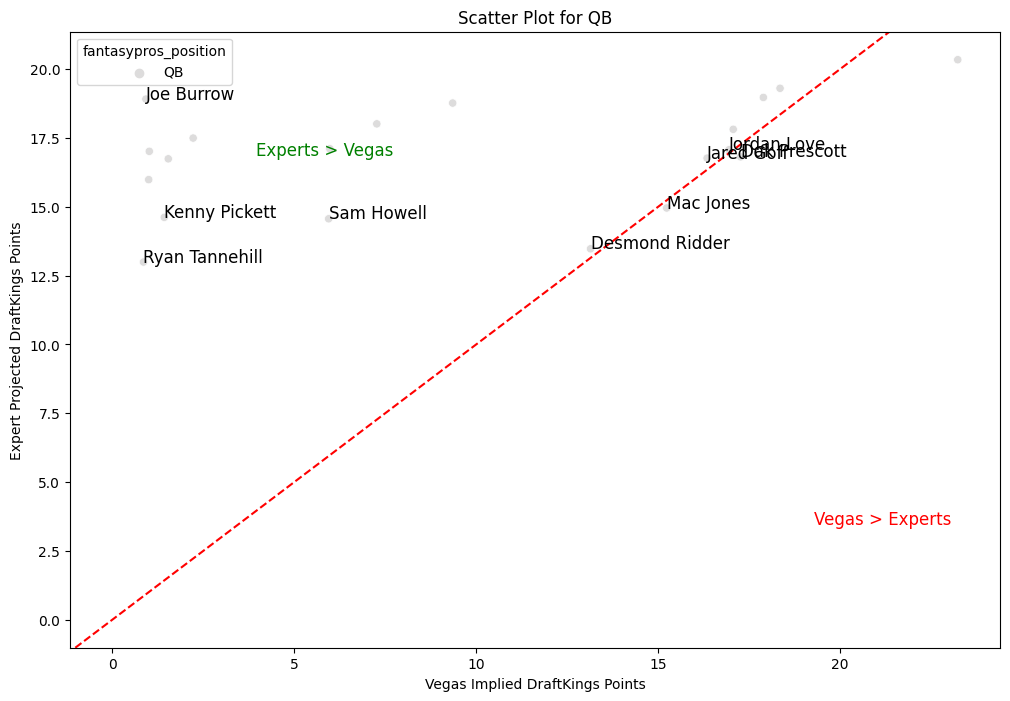

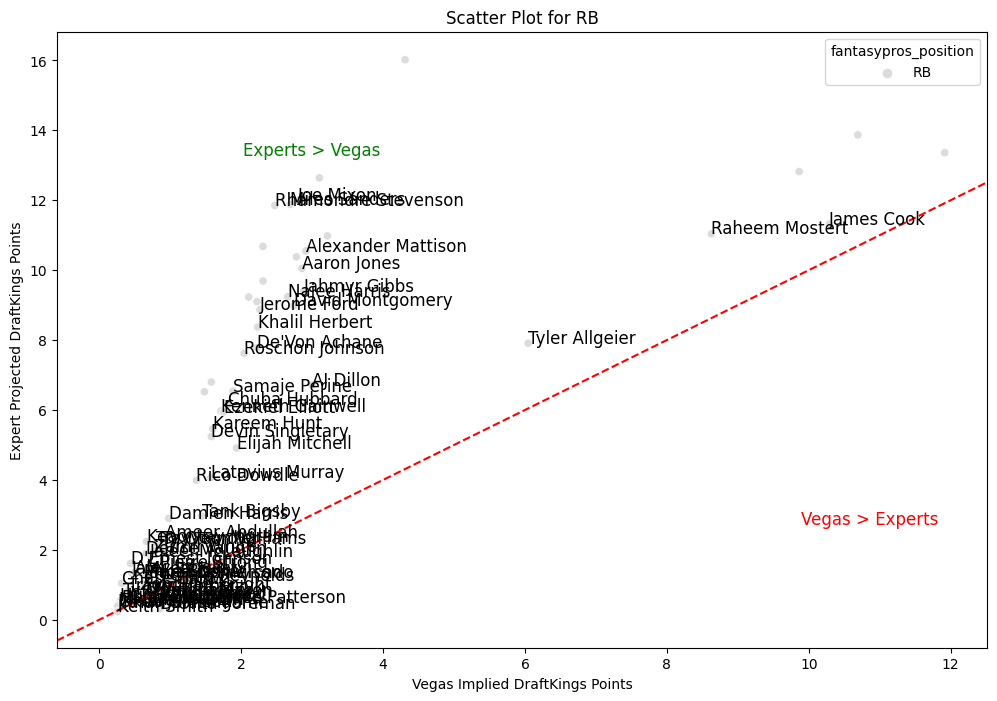

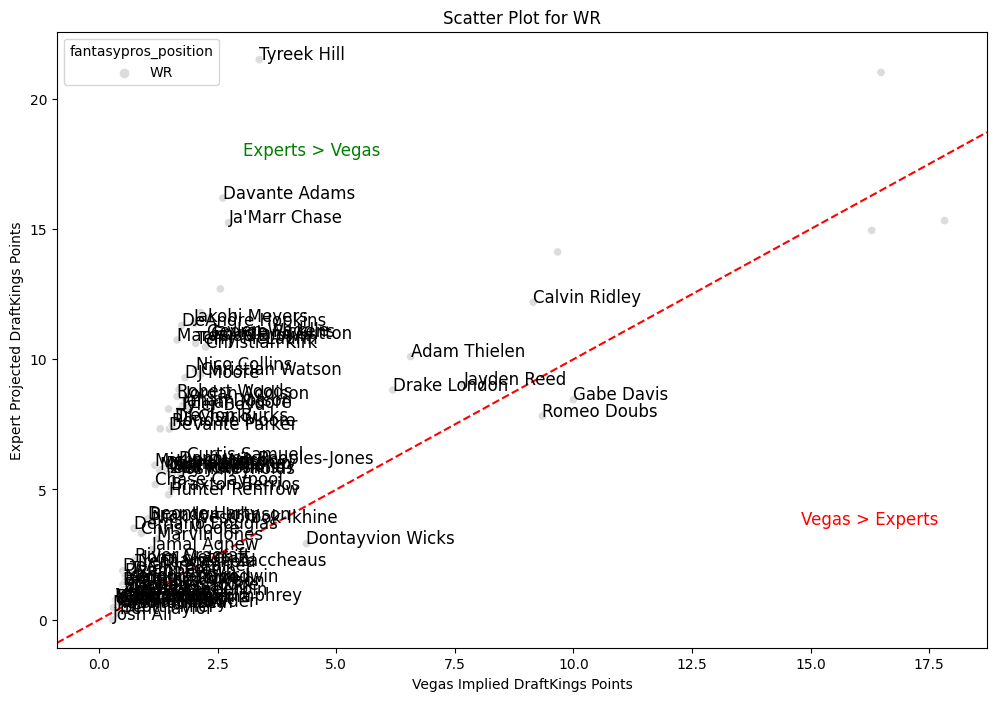

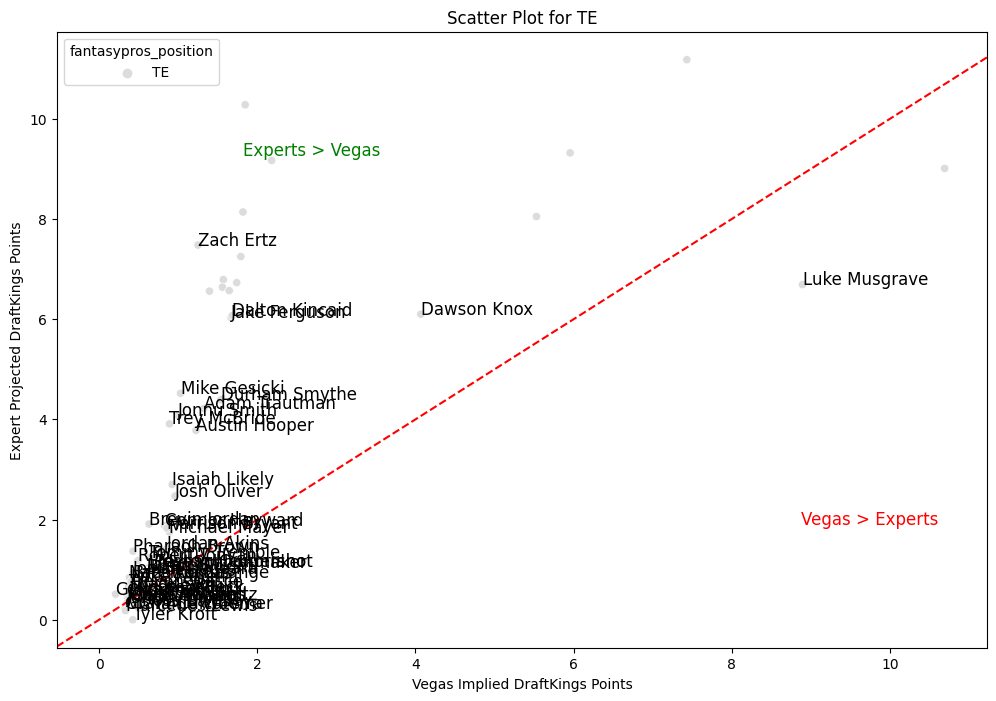

In [157]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the positional rank based on implied and projected points
for position in final_df['fantasypros_position'].unique():
    subset_df = final_df[final_df['fantasypros_position'] == position]
    final_df.loc[subset_df.index, 'implied_positional_rank'] = subset_df['implied_draftkings_fantasy_points'].rank(ascending=False)
    final_df.loc[subset_df.index, 'projected_positional_rank'] = subset_df['projected_draftkings_fantasy_points'].rank(ascending=False)

# Calculate the difference in ranks
final_df['rank_difference'] = final_df['implied_positional_rank'] - final_df['projected_positional_rank']

# Loop through each unique position to create scatter plots
for position in final_df['fantasypros_position'].unique():
    subset_df = final_df[final_df['fantasypros_position'] == position]

    # Identify players whose rank difference is more than 4 in either direction
    label_indices = subset_df[subset_df['rank_difference'].abs() > 6].index

    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=subset_df, x='implied_draftkings_fantasy_points', y='projected_draftkings_fantasy_points', hue='fantasypros_position', palette='coolwarm')

    # Label the points
    for i in label_indices:
        plt.text(subset_df.loc[i, 'implied_draftkings_fantasy_points'], subset_df.loc[i, 'projected_draftkings_fantasy_points'], subset_df.loc[i, 'fantasypros_name'], fontsize=12)

    plt.title(f'Scatter Plot for {position}')
    plt.xlabel('Vegas Implied DraftKings Points')
    plt.ylabel('Expert Projected DraftKings Points')
    plt.axline([0, 0], [1, 1], color='red', linestyle='--')

    # Add annotations
    plt.annotate('Experts > Vegas', xy=(0.2, 0.8), xycoords='axes fraction', fontsize=12, color='green')
    plt.annotate('Vegas > Experts', xy=(0.8, 0.2), xycoords='axes fraction', fontsize=12, color='red')

    plt.show()


In [158]:
import pandas as pd

# Calculate the difference between implied and career mean
final_df['difference'] = final_df['implied_draftkings_fantasy_points'] - final_df['projected_draftkings_fantasy_points']

# Sort by the difference and drop NaNs
sorted_df = final_df.dropna(subset=['fantasypros_name']).sort_values(by='difference', ascending=False)

# Function to apply styling
def highlight_diff(s):
    if s['difference'] > 0:
        return ['color: green' if v == s['difference'] else '' for v in s]
    elif s['difference'] < 0:
        return ['color: red' if v == s['difference'] else '' for v in s]
    else:
        return ['' for _ in s]

# Apply styling and display the top 10 positive and negative differences for each position
for position in sorted_df['fantasypros_position'].unique():
    position_df = sorted_df[sorted_df['fantasypros_position'] == position]
    top_10_positive = position_df.head(10)
    top_10_negative = position_df.tail(10)

    print(f"Top 10 Positive Differences for {position}")
    display(top_10_positive.style.apply(highlight_diff, axis=1))

    print(f"Top 10 Negative Differences for {position}")
    display(top_10_negative.style.apply(highlight_diff, axis=1))




Top 10 Positive Differences for QB


,fantasypros_name,most_recent_team,fantasypros_position,projected_draftkings_fantasy_points,implied_draftkings_fantasy_points,merge_name,commence_time,implied_positional_rank,projected_positional_rank,rank_difference,difference
0,Josh Allen,BUF,QB,20.344000,23.236765,joshallen,2023-10-01T17:00:00Z,1.000000,3.000000,-2.000000,2.892765
17,Dak Prescott,DAL,QB,16.816000,17.268407,dakprescott,2023-10-01T20:25:00Z,4.000000,16.000000,-12.000000,0.452407
23,Mac Jones,NE,QB,14.958000,15.236822,macjones,2023-10-01T20:25:00Z,8.000000,22.000000,-14.000000,0.278822
15,Jordan Love,GB,QB,17.072000,16.949107,jordanlove,2023-09-29T00:15:00Z,6.000000,14.000000,-8.000000,-0.122893
26,Desmond Ridder,ATL,QB,13.476000,13.144648,desmondridder,2023-10-01T13:30:00Z,9.000000,28.000000,-19.000000,-0.331352
18,Jared Goff,DET,QB,16.768000,16.347789,jaredgoff,2023-09-29T00:15:00Z,7.000000,17.000000,-10.000000,-0.420211
11,Trevor Lawrence,JAX,QB,17.816000,17.065701,trevorlawrence,2023-10-01T13:30:00Z,5.000000,10.000000,-5.000000,-0.750299
6,Kirk Cousins,MIN,QB,19.306000,18.352600,kirkcousins,2023-10-01T17:01:00Z,2.000000,4.000000,-2.000000,-0.953400
4,Tua Tagovailoa,MIA,QB,18.974000,17.894112,tuatagovailoa,2023-10-01T17:00:00Z,3.000000,5.000000,-2.000000,-1.079888
22,Sam Howell,WAS,QB,14.566000,5.946033,samhowell,2023-10-01T17:01:00Z,13.000000,24.000000,-11.000000,-8.619967


Top 10 Negative Differences for QB


,fantasypros_name,most_recent_team,fantasypros_position,projected_draftkings_fantasy_points,implied_draftkings_fantasy_points,merge_name,commence_time,implied_positional_rank,projected_positional_rank,rank_difference,difference
84,Tyson Bagent,nan,QB,0.000000,nan,tysonbagent,nan,nan,79.500000,nan,nan
85,Mason Rudolph,nan,QB,0.000000,nan,masonrudolph,nan,nan,79.500000,nan,nan
86,Ben DiNucci,nan,QB,0.000000,nan,bendinucci,nan,nan,79.500000,nan,nan
87,Case Keenum,nan,QB,0.000000,nan,casekeenum,nan,nan,79.500000,nan,nan
88,Malik Cunningham,nan,QB,0.000000,nan,malikcunningham,nan,nan,79.500000,nan,nan
89,Sam Ehlinger,nan,QB,0.000000,nan,samehlinger,nan,nan,79.500000,nan,nan
90,Skylar Thompson,nan,QB,0.000000,nan,skylarthompson,nan,nan,79.500000,nan,nan
91,Tyler Huntley,nan,QB,0.000000,nan,tylerhuntley,nan,nan,79.500000,nan,nan
92,Jaren Hall,nan,QB,0.000000,nan,jarenhall,nan,nan,79.500000,nan,nan
580,Feleipe Franks,nan,QB,0.000000,nan,feleipefranks,nan,nan,79.500000,nan,nan


Top 10 Positive Differences for WR


,fantasypros_name,most_recent_team,fantasypros_position,projected_draftkings_fantasy_points,implied_draftkings_fantasy_points,merge_name,commence_time,implied_positional_rank,projected_positional_rank,rank_difference,difference
111,Stefon Diggs,BUF,WR,15.320000,17.824928,stefondiggs,2023-10-01T17:00:00Z,1.000000,5.000000,-4.000000,2.504928
165,Gabe Davis,BUF,WR,8.450000,9.996080,gabedavis,2023-10-01T17:00:00Z,4.000000,48.000000,-44.000000,1.546080
187,Romeo Doubs,GB,WR,7.820000,9.342331,romeodoubs,2023-09-29T00:15:00Z,6.000000,53.000000,-47.000000,1.522331
301,Dontayvion Wicks,GB,WR,2.920000,4.370373,dontayvionwicks,2023-09-29T00:15:00Z,11.000000,104.000000,-93.000000,1.450373
119,Amon-Ra St.,DET,WR,14.950000,16.288833,amonrast,2023-09-29T00:15:00Z,3.000000,7.000000,-4.000000,1.338833
565,Josh Ali,ATL,WR,0.000000,0.279919,joshali,2023-10-01T13:30:00Z,96.000000,211.000000,-115.000000,0.279919
459,Scott Miller,TB,WR,0.330000,0.488636,scottmiller,2023-10-01T13:30:00Z,87.000000,165.000000,-78.000000,0.158636
490,Trent Taylor,CIN,WR,0.230000,0.373626,trenttaylor,2023-10-01T17:01:00Z,92.000000,167.500000,-75.500000,0.143626
444,Trenton Irwin,CIN,WR,0.460000,0.545455,trentonirwin,2023-10-01T17:01:00Z,81.000000,158.500000,-77.500000,0.085455
420,Jalen Tolbert,DAL,WR,0.640000,0.690789,jalentolbert,2023-10-01T20:25:00Z,72.000000,150.000000,-78.000000,0.050789


Top 10 Negative Differences for WR


,fantasypros_name,most_recent_team,fantasypros_position,projected_draftkings_fantasy_points,implied_draftkings_fantasy_points,merge_name,commence_time,implied_positional_rank,projected_positional_rank,rank_difference,difference
616,Tyler Johnson,nan,WR,0.000000,nan,tylerjohnson,nan,nan,211.000000,nan,nan
617,A.T. Perry,nan,WR,0.000000,nan,atperry,nan,nan,211.000000,nan,nan
618,Michael Bandy,nan,WR,0.000000,nan,michaelbandy,nan,nan,211.000000,nan,nan
619,Tanner Conner,nan,WR,0.000000,nan,tannerconner,nan,nan,211.000000,nan,nan
620,Mitchell Tinsley,nan,WR,0.000000,nan,mitchelltinsley,nan,nan,211.000000,nan,nan
622,Daurice Fountain,nan,WR,0.000000,nan,dauricefountain,nan,nan,211.000000,nan,nan
625,Grant DuBose,nan,WR,0.000000,nan,grantdubose,nan,nan,211.000000,nan,nan
626,Easop Winston,nan,WR,0.000000,nan,easopwinston,nan,nan,211.000000,nan,nan
628,Malik Taylor,nan,WR,0.000000,nan,maliktaylor,nan,nan,211.000000,nan,nan
629,Raleigh Webb,nan,WR,0.000000,nan,raleighwebb,nan,nan,211.000000,nan,nan


Top 10 Positive Differences for TE


,fantasypros_name,most_recent_team,fantasypros_position,projected_draftkings_fantasy_points,implied_draftkings_fantasy_points,merge_name,commence_time,implied_positional_rank,projected_positional_rank,rank_difference,difference
213,Luke Musgrave,GB,TE,6.690000,8.894544,lukemusgrave,2023-09-29T00:15:00Z,2.000000,16.000000,-14.000000,2.204544
177,Sam LaPorta,DET,TE,9.010000,10.691692,samlaporta,2023-09-29T00:15:00Z,1.000000,7.000000,-6.000000,1.681692
594,Tyler Kroft,SF,TE,0.000000,0.425776,tylerkroft,2023-10-01T17:00:00Z,47.000000,125.500000,-78.500000,0.425776
477,Charlie Woerner,SF,TE,0.230000,0.500000,charliewoerner,2023-10-01T20:25:00Z,40.000000,99.000000,-59.000000,0.270000
455,Ross Dwelley,SF,TE,0.290000,0.545455,rossdwelley,2023-10-01T20:25:00Z,39.000000,93.000000,-54.000000,0.255455
501,Marcedes Lewis,GB,TE,0.180000,0.333556,marcedeslewis,2023-10-01T17:01:00Z,58.000000,108.000000,-50.000000,0.153556
487,Grant Calcaterra,PHI,TE,0.220000,0.324324,grantcalcaterra,2023-10-01T17:01:00Z,59.000000,102.500000,-43.500000,0.104324
473,Johnny Mundt,MIN,TE,0.340000,0.352941,johnnymundt,2023-10-01T17:01:00Z,56.500000,91.000000,-34.500000,0.012941
472,Geoff Swaim,TEN,TE,0.390000,0.400000,geoffswaim,2023-10-01T20:25:00Z,50.000000,90.000000,-40.000000,0.010000
443,Chris Manhertz,DEN,TE,0.410000,0.411111,chrismanhertz,2023-10-01T17:01:00Z,48.000000,87.500000,-39.500000,0.001111


Top 10 Negative Differences for TE


,fantasypros_name,most_recent_team,fantasypros_position,projected_draftkings_fantasy_points,implied_draftkings_fantasy_points,merge_name,commence_time,implied_positional_rank,projected_positional_rank,rank_difference,difference
572,Jacob Harris,nan,TE,0.000000,nan,jacobharris,nan,nan,125.500000,nan,nan
574,Kevin Rader,nan,TE,0.000000,nan,kevinrader,nan,nan,125.500000,nan,nan
582,Brady Russell,nan,TE,0.000000,nan,bradyrussell,nan,nan,125.500000,nan,nan
591,Hunter Kampmoyer,nan,TE,0.000000,nan,hunterkampmoyer,nan,nan,125.500000,nan,nan
595,Dalton Keene,nan,TE,0.000000,nan,daltonkeene,nan,nan,125.500000,nan,nan
596,Elijah Higgins,nan,TE,0.000000,nan,elijahhiggins,nan,nan,125.500000,nan,nan
599,Miller Forristall,nan,TE,0.000000,nan,millerforristall,nan,nan,125.500000,nan,nan
604,Nick Bowers,nan,TE,0.000000,nan,nickbowers,nan,nan,125.500000,nan,nan
624,Sean McKeon,nan,TE,0.000000,nan,seanmckeon,nan,nan,125.500000,nan,nan
630,Brandon Dillon,nan,TE,0.000000,nan,brandondillon,nan,nan,125.500000,nan,nan


Top 10 Positive Differences for RB


,fantasypros_name,most_recent_team,fantasypros_position,projected_draftkings_fantasy_points,implied_draftkings_fantasy_points,merge_name,commence_time,implied_positional_rank,projected_positional_rank,rank_difference,difference
453,D'Onta Foreman,CHI,RB,0.320000,0.857143,dontaforeman,2023-10-01T17:01:00Z,47.500000,115.000000,-67.500000,0.537143
434,Cordarrelle Patterson,ATL,RB,0.500000,1.000000,cordarrellepatterson,2023-10-01T13:30:00Z,41.000000,105.500000,-64.500000,0.500000
390,Jordan Mason,SF,RB,0.710000,0.888889,jordanmason,2023-10-01T20:25:00Z,45.500000,96.000000,-50.500000,0.178889
432,Salvon Ahmed,MIA,RB,0.610000,0.654040,salvonahmed,2023-10-01T17:00:00Z,56.000000,101.000000,-45.000000,0.044040
467,Keith Smith,ATL,RB,0.230000,0.257143,keithsmith,2023-10-01T13:30:00Z,74.000000,124.000000,-50.000000,0.027143
470,Khari Blasingame,CHI,RB,0.360000,0.336364,khariblasingame,2023-10-01T17:01:00Z,67.500000,114.000000,-46.500000,-0.023636
401,Kyle Juszczyk,SF,RB,0.800000,0.774194,kylejuszczyk,2023-10-01T20:25:00Z,50.500000,94.000000,-43.500000,-0.025806
439,Brandon Bolden,LV,RB,0.490000,0.428571,brandonbolden,2023-10-01T20:06:00Z,64.500000,107.000000,-42.500000,-0.061429
460,Jakob Johnson,LV,RB,0.390000,0.260870,jakobjohnson,2023-10-01T20:06:00Z,73.000000,111.000000,-38.000000,-0.129130
428,Chris Rodriguez,WAS,RB,0.560000,0.428571,chrisrodriguez,2023-10-01T17:01:00Z,64.500000,102.000000,-37.500000,-0.131429


Top 10 Negative Differences for RB


,fantasypros_name,most_recent_team,fantasypros_position,projected_draftkings_fantasy_points,implied_draftkings_fantasy_points,merge_name,commence_time,implied_positional_rank,projected_positional_rank,rank_difference,difference
585,Kevin Harris,nan,RB,0.000000,nan,kevinharris,nan,nan,139.000000,nan,nan
587,Zander Horvath,nan,RB,0.000000,nan,zanderhorvath,nan,nan,139.000000,nan,nan
590,Austin Walter,nan,RB,0.000000,nan,austinwalter,nan,nan,139.000000,nan,nan
593,Jeremy McNichols,nan,RB,0.000000,nan,jeremymcnichols,nan,nan,139.000000,nan,nan
598,Israel Abanikanda,nan,RB,0.000000,nan,israelabanikanda,nan,nan,139.000000,nan,nan
602,Devine Ozigbo,nan,RB,0.000000,nan,devineozigbo,nan,nan,139.000000,nan,nan
611,Dwayne Washington,nan,RB,0.000000,nan,dwaynewashington,nan,nan,139.000000,nan,nan
621,Javian Hawkins,nan,RB,0.000000,nan,javianhawkins,nan,nan,139.000000,nan,nan
623,Deneric Prince,nan,RB,0.000000,nan,denericprince,nan,nan,139.000000,nan,nan
627,Demetric Felton,nan,RB,0.000000,nan,demetricfelton,nan,nan,139.000000,nan,nan


In [159]:
# Fill 'implied_draftkings_fantasy_points' with 'projected_draftkings_fantasy_points' where 'player_display_name' is null
final_df.loc[final_df['most_recent_team'].isna(), 'implied_draftkings_fantasy_points'] = final_df['projected_draftkings_fantasy_points']


In [160]:
final_df

,fantasypros_name,most_recent_team,fantasypros_position,projected_draftkings_fantasy_points,implied_draftkings_fantasy_points,merge_name,commence_time,implied_positional_rank,projected_positional_rank,rank_difference,difference
0,Josh Allen,BUF,QB,20.344,23.236765,joshallen,2023-10-01T17:00:00Z,1.0,3.0,-2.0,2.892765
1,Jalen Hurts,PHI,QB,18.770,9.355014,jalenhurts,2023-10-01T17:01:00Z,10.0,7.0,3.0,-9.414986
2,Patrick Mahomes,NaN,QB,20.932,20.932000,patrickmahomes,NaN,NaN,1.0,NaN,NaN
3,Justin Herbert,NaN,QB,20.388,20.388000,justinherbert,NaN,NaN,2.0,NaN,NaN
4,Tua Tagovailoa,MIA,QB,18.974,17.894112,tuatagovailoa,2023-10-01T17:00:00Z,3.0,5.0,-2.0,-1.079888
...,...,...,...,...,...,...,...,...,...,...,...
626,Easop Winston,NaN,WR,0.000,0.000000,easopwinston,NaN,NaN,211.0,NaN,NaN
627,Demetric Felton,NaN,RB,0.000,0.000000,demetricfelton,NaN,NaN,139.0,NaN,NaN
628,Malik Taylor,NaN,WR,0.000,0.000000,maliktaylor,NaN,NaN,211.0,NaN,NaN
629,Raleigh Webb,NaN,WR,0.000,0.000000,raleighwebb,NaN,NaN,211.0,NaN,NaN


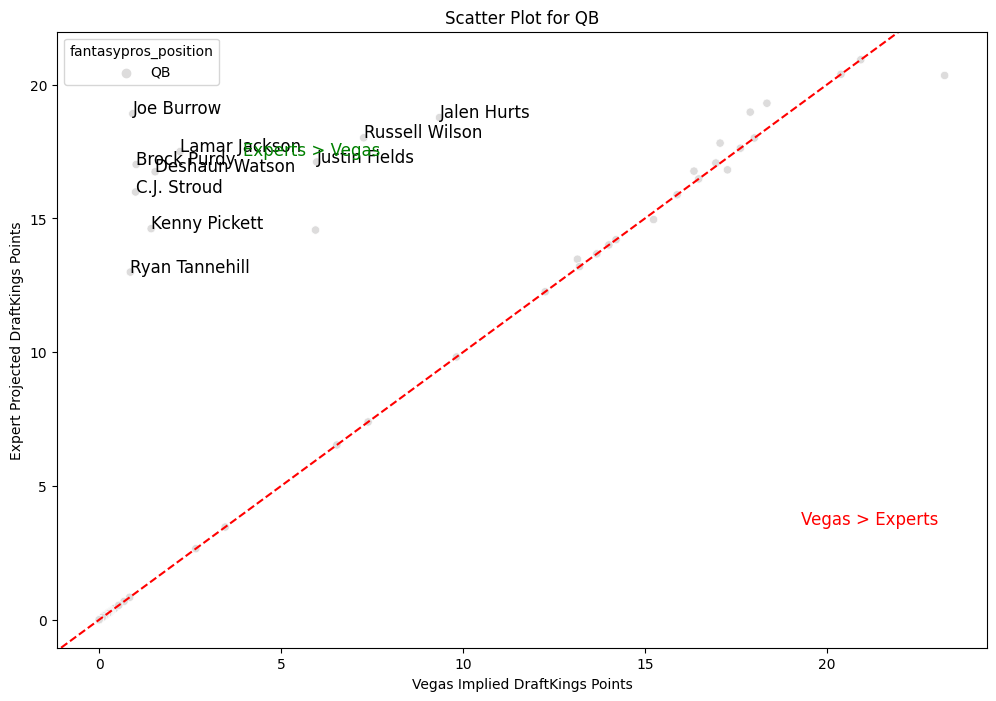

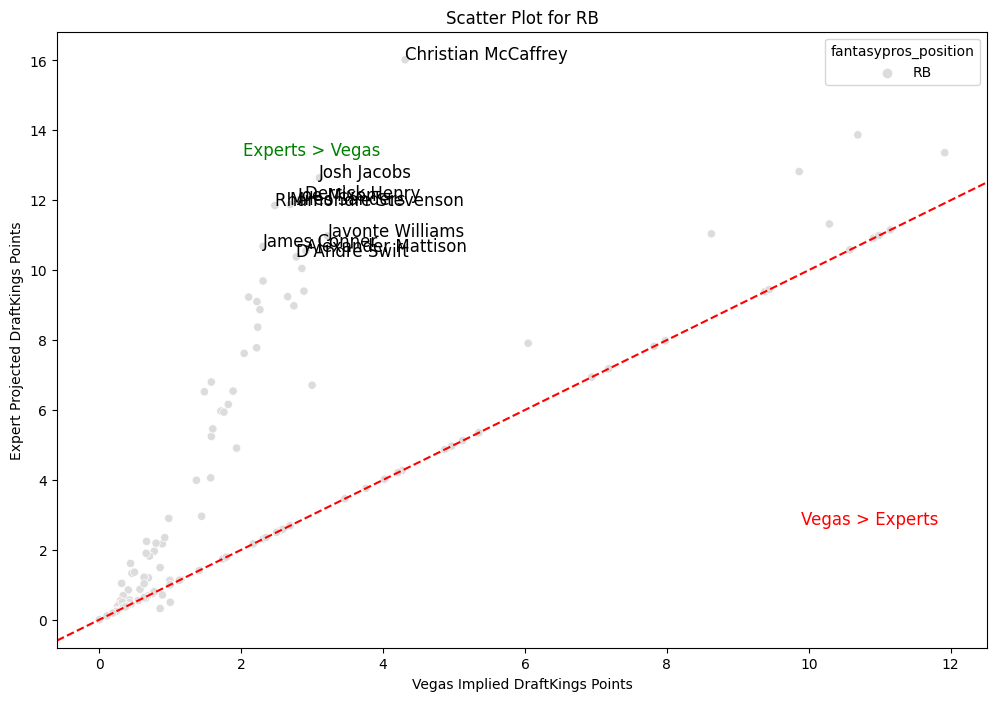

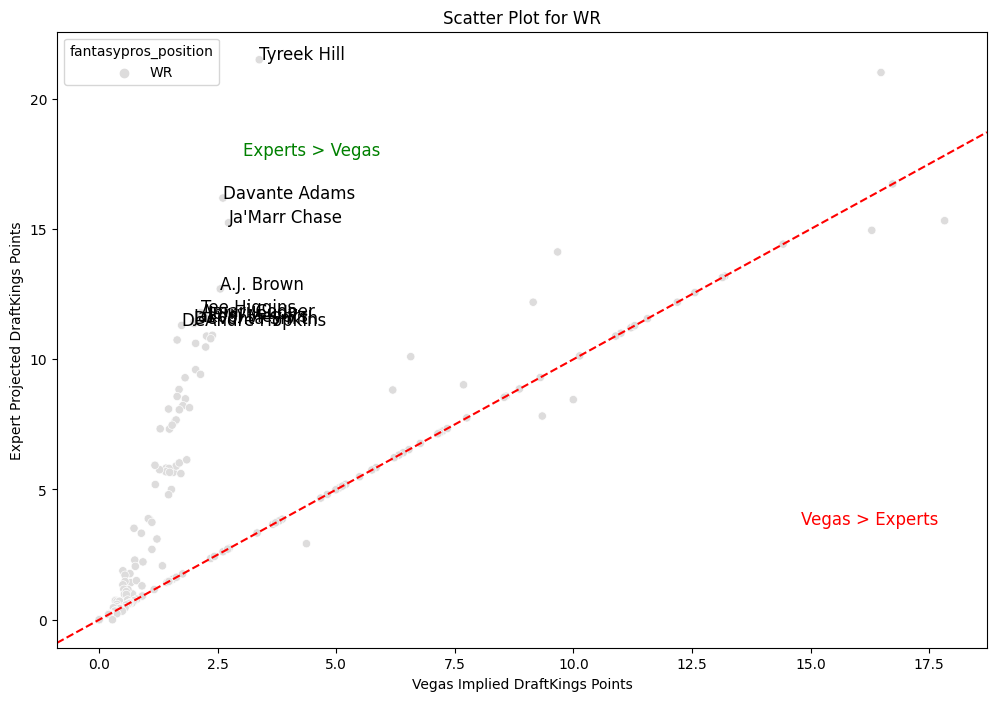

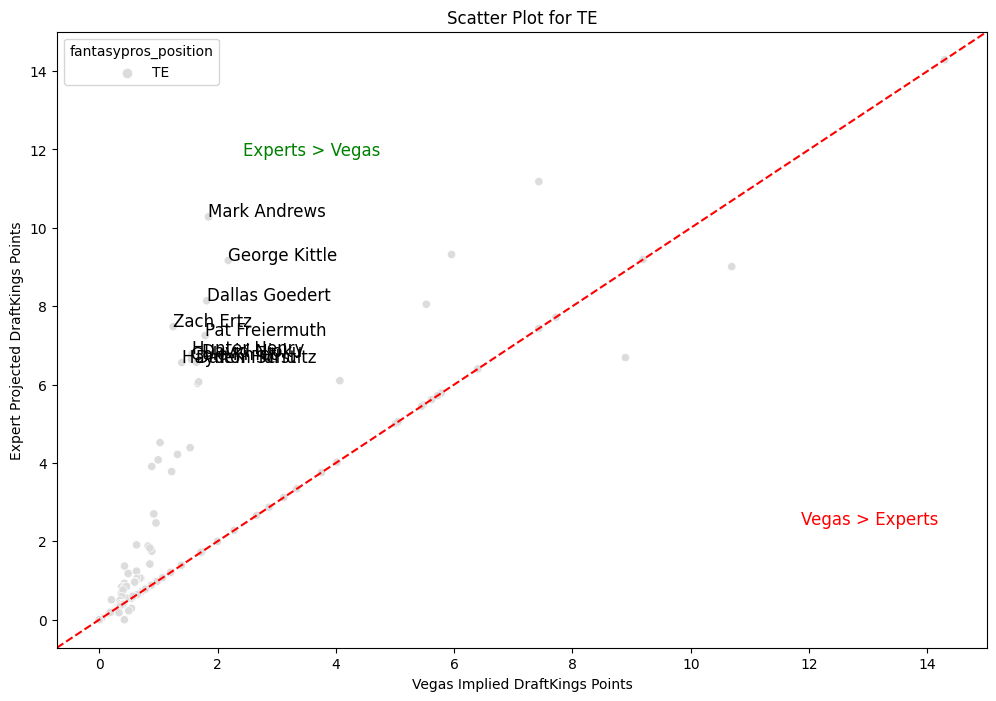

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the difference between expert and implied points
final_df['difference'] = final_df['projected_draftkings_fantasy_points'] - final_df['implied_draftkings_fantasy_points']

# Loop through each unique position
for position in final_df['fantasypros_position'].unique():
    subset_df = final_df[final_df['fantasypros_position'] == position]

    # Sort by absolute difference and get top 10
    top_10_diff = subset_df['difference'].abs().sort_values(ascending=False).head(10).index

    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=subset_df, x='implied_draftkings_fantasy_points', y='projected_draftkings_fantasy_points', hue='fantasypros_position', palette='coolwarm')

    # Label the points
    for i in top_10_diff:
        plt.text(subset_df.loc[i, 'implied_draftkings_fantasy_points'], subset_df.loc[i, 'projected_draftkings_fantasy_points'], subset_df.loc[i, 'fantasypros_name'], fontsize=12)

    plt.title(f'Scatter Plot for {position}')
    plt.xlabel('Vegas Implied DraftKings Points')
    plt.ylabel('Expert Projected DraftKings Points')
    plt.axline([0, 0], [1, 1], color='red', linestyle='--')

    # Add annotations
    plt.annotate('Experts > Vegas', xy=(0.2, 0.8), xycoords='axes fraction', fontsize=12, color='green')
    plt.annotate('Vegas > Experts', xy=(0.8, 0.2), xycoords='axes fraction', fontsize=12, color='red')

    plt.show()


In [162]:
# Sort the DataFrame by 'fantasypros_position' and 'difference'
final_df.sort_values(by=['fantasypros_position', 'difference'], inplace=True)

# Loop through each unique position to find the top 10 players with the highest negative difference
for position in final_df['fantasypros_position'].unique():
    subset_df = final_df[final_df['fantasypros_position'] == position]

    # Filter out the top 10 players with the highest negative difference and a minimum difference of 5 points
    top_10_negative_diff = subset_df[subset_df['difference'] >= -5].head(10)

    # Display the top 10 players with the highest negative difference for the current position
    if not top_10_negative_diff.empty:
        print(f"Top 10 Players with the Highest Negative Difference (Vegas > Experts) for {position}:")
        display(top_10_negative_diff[['fantasypros_name', 'implied_draftkings_fantasy_points', 'projected_draftkings_fantasy_points', 'difference']])
    else:
        print(f"No players with a minimum difference of 5 points for {position}.")


Top 10 Players with the Highest Negative Difference (Vegas > Experts) for QB:


,fantasypros_name,implied_draftkings_fantasy_points,projected_draftkings_fantasy_points,difference
0,Josh Allen,23.236765,20.344,-2.892765
17,Dak Prescott,17.268407,16.816,-0.452407
23,Mac Jones,15.236822,14.958,-0.278822
2,Patrick Mahomes,20.932000,20.932,0.000000
3,Justin Herbert,20.388000,20.388,0.000000
9,Daniel Jones,17.624000,17.624,0.000000
12,Geno Smith,18.006000,18.006,0.000000
16,Anthony Richardson,15.884000,15.884,0.000000
19,Matthew Stafford,16.476000,16.476,0.000000
24,Baker Mayfield,14.206000,14.206,0.000000


Top 10 Players with the Highest Negative Difference (Vegas > Experts) for RB:


,fantasypros_name,implied_draftkings_fantasy_points,projected_draftkings_fantasy_points,difference
453,D'Onta Foreman,0.857143,0.32,-0.537143
434,Cordarrelle Patterson,1.000000,0.50,-0.500000
390,Jordan Mason,0.888889,0.71,-0.178889
432,Salvon Ahmed,0.654040,0.61,-0.044040
467,Keith Smith,0.257143,0.23,-0.027143
97,Kenneth Walker,10.940000,10.94,0.000000
101,Zack Moss,10.910000,10.91,0.000000
104,Kyren Williams,10.580000,10.58,0.000000
123,Alvin Kamara,11.150000,11.15,0.000000
125,Isiah Pacheco,9.380000,9.38,0.000000


Top 10 Players with the Highest Negative Difference (Vegas > Experts) for TE:


,fantasypros_name,implied_draftkings_fantasy_points,projected_draftkings_fantasy_points,difference
213,Luke Musgrave,8.894544,6.69,-2.204544
177,Sam LaPorta,10.691692,9.01,-1.681692
594,Tyler Kroft,0.425776,0.00,-0.425776
477,Charlie Woerner,0.500000,0.23,-0.270000
455,Ross Dwelley,0.545455,0.29,-0.255455
501,Marcedes Lewis,0.333556,0.18,-0.153556
487,Grant Calcaterra,0.324324,0.22,-0.104324
473,Johnny Mundt,0.352941,0.34,-0.012941
472,Geoff Swaim,0.400000,0.39,-0.010000
443,Chris Manhertz,0.411111,0.41,-0.001111


Top 10 Players with the Highest Negative Difference (Vegas > Experts) for WR:


,fantasypros_name,implied_draftkings_fantasy_points,projected_draftkings_fantasy_points,difference
111,Stefon Diggs,17.824928,15.32,-2.504928
165,Gabe Davis,9.996080,8.45,-1.546080
187,Romeo Doubs,9.342331,7.82,-1.522331
301,Dontayvion Wicks,4.370373,2.92,-1.450373
119,Amon-Ra St.,16.288833,14.95,-1.338833
565,Josh Ali,0.279919,0.00,-0.279919
459,Scott Miller,0.488636,0.33,-0.158636
490,Trent Taylor,0.373626,0.23,-0.143626
444,Trenton Irwin,0.545455,0.46,-0.085455
420,Jalen Tolbert,0.690789,0.64,-0.050789


In [163]:
# Filter players with a projected total of at least 5 points
filtered_df = final_df[final_df['projected_draftkings_fantasy_points'] >= 5]

# Sort the DataFrame by 'difference'
filtered_df.sort_values(by='difference', inplace=True)

# Get the top 10 players with the highest negative difference (Vegas > Experts)
top_10_negative_diff = filtered_df.head(10)

# Display the top 10 players with the highest negative difference
if not top_10_negative_diff.empty:
    print("Top 10 Players with the Highest Negative Difference (Vegas > Experts) Across All Positions:")
    display(top_10_negative_diff[['fantasypros_name', 'fantasypros_position', 'implied_draftkings_fantasy_points', 'projected_draftkings_fantasy_points', 'difference']])
else:
    print("No players meet the criteria.")


Top 10 Players with the Highest Negative Difference (Vegas > Experts) Across All Positions:


/var/folders/kj/29dyy8nn54v_615jgbd59t7h0000gn/T/ipykernel_5069/2682031787.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.sort_values(by='difference', inplace=True)


,fantasypros_name,fantasypros_position,implied_draftkings_fantasy_points,projected_draftkings_fantasy_points,difference
0,Josh Allen,QB,23.236765,20.344,-2.892765
111,Stefon Diggs,WR,17.824928,15.320,-2.504928
213,Luke Musgrave,TE,8.894544,6.690,-2.204544
177,Sam LaPorta,TE,10.691692,9.010,-1.681692
165,Gabe Davis,WR,9.996080,8.450,-1.546080
187,Romeo Doubs,WR,9.342331,7.820,-1.522331
119,Amon-Ra St.,WR,16.288833,14.950,-1.338833
17,Dak Prescott,QB,17.268407,16.816,-0.452407
23,Mac Jones,QB,15.236822,14.958,-0.278822
190,Josh Downs,WR,8.540000,8.540,0.000000


In [164]:
final_df.columns

Index(['fantasypros_name', 'most_recent_team', 'fantasypros_position',
       'projected_draftkings_fantasy_points',
       'implied_draftkings_fantasy_points', 'merge_name', 'commence_time',
       'implied_positional_rank', 'projected_positional_rank',
       'rank_difference', 'difference'],
      dtype='object')

In [165]:
# Drop rows where 'most_recent_team' is NaN
final_df.dropna(subset=['most_recent_team'], inplace=True)

In [166]:
selected_columns

,player_display_name,merge_name,position,season,week,draftkings_fantasy_points
3,Matthew Stafford,matthewstafford,QB,2023,3,13.46
4,Jimmy Graham,jimmygraham,TE,2023,3,7.80
5,Blaine Gabbert,blainegabbert,QB,2023,3,-0.86
6,Andy Dalton,andydalton,QB,2023,3,26.54
9,Randall Cobb,randallcobb,WR,2023,3,2.20
...,...,...,...,...,...,...
921,Jahmyr Gibbs,jahmyrgibbs,RB,2023,3,9.20
924,Luke Musgrave,lukemusgrave,TE,2023,3,10.90
927,Jayden Reed,jaydenreed,WR,2023,3,9.30
932,C.J. Stroud,cjstroud,QB,2023,3,20.60


In [ ]:
# Save the DataFrame to a CSV file
final_df.to_csv('/Users/nick/market_implied_fantasy_football_tools/data/processed/market_implied_projections.csv', index=False)


In [ ]:
# Assuming 'df' contains your selected data, and 'final_df' is your main DataFrame
final_df = final_df[(final_df['implied_draftkings_fantasy_points'] > 2)]

# Step 1: Merge the data
validation_df = final_df.merge(selected_columns, left_on=['merge_name'], right_on=['merge_name'], how='left')

# Step 2: Calculate the error in terms of fantasy points
validation_df['projection_error'] = validation_df['draftkings_fantasy_points'] - validation_df['projected_draftkings_fantasy_points']
validation_df['implied_error'] = validation_df['draftkings_fantasy_points'] - validation_df['implied_draftkings_fantasy_points']


# Step 3: Rank players by actual fantasy points
validation_df['actual_rank'] = validation_df.groupby('fantasypros_position')['draftkings_fantasy_points'].rank(ascending=False, method='dense')

# Step 4: Calculate rank differences for implied and projected points
validation_df['implied_rank'] = validation_df.groupby('fantasypros_position')['implied_draftkings_fantasy_points'].rank(ascending=False, method='dense')
validation_df['projected_rank'] = validation_df.groupby('fantasypros_position')['projected_draftkings_fantasy_points'].rank(ascending=False, method='dense')
validation_df['rank_difference_implied'] = validation_df['actual_rank'] - validation_df['implied_rank']
validation_df['rank_difference_projected'] = validation_df['actual_rank'] - validation_df['projected_rank']

# Step 5: Filter relevant players based on your criteria
relevant_players = {
    'QB': 20,    # Top 12 QBs
    'RB': 40,    # Top 24 RBs
    'WR': 60,    # Top 36 WRs
    'TE': 20     # Top 12 TEs
}

# Filter based on positions and relevant player counts
for position, count in relevant_players.items():
    filtered_data = validation_df[validation_df['fantasypros_position'] == position].sort_values(by='actual_rank')
    relevant_data = filtered_data.head(count)

    # Now you can analyze relevant_data as needed

# Calculate average error
average_error = validation_df['projection_error'].mean()
print("ECR Average Error:", average_error)

average_error = validation_df['implied_error'].mean()
print("Implied Average Error:", average_error)


# You can also visualize the data and rank differences as per your requirements.


In [ ]:
validation_df.isnull().sum()

In [ ]:
# Assuming 'df' contains your selected data, and 'final_df' is your main DataFrame
final_df = final_df[(final_df['projected_draftkings_fantasy_points'] > 2)]

In [ ]:
import numpy as np

def calculate_metrics(data):
    actual = data['draftkings_fantasy_points']
    projected = data['projected_draftkings_fantasy_points']
    implied = data['implied_draftkings_fantasy_points']


    # Set a floor value for actual fantasy points
    floor_value = 1.0  # You can adjust this as needed

    # Calculate relative error and percent error for both projections
    epsilon = 1e-6  # Small positive value to avoid division by zero
    relative_error_projected = np.abs(actual - projected) / (actual + epsilon)
    relative_error_projected = np.where(actual < floor_value, 0, relative_error_projected)  # Set relative error to 0 when actual < floor_value
    percent_error_projected = (np.abs(actual - projected) / (actual + epsilon)) * 100
    percent_error_projected = np.where(actual < floor_value, 0, percent_error_projected)  # Set percent error to 0 when actual < floor_value

    relative_error_implied = np.abs(actual - implied) / (actual + epsilon)
    relative_error_implied = np.where(actual < floor_value, 0, relative_error_implied)  # Set relative error to 0 when actual < floor_value
    percent_error_implied = (np.abs(actual - implied) / (actual + epsilon)) * 100
    percent_error_implied = np.where(actual < floor_value, 0, percent_error_implied)  # Set percent error to 0 when actual < floor_value

    # Calculate RMSE and MAE for both projections
    rmse_projected = np.sqrt(np.mean((actual - projected) ** 2))
    mae_projected = np.mean(np.abs(actual - projected))

    rmse_implied = np.sqrt(np.mean((actual - implied) ** 2))
    mae_implied = np.mean(np.abs(actual - implied))

    return {
        'Projected RMSE': rmse_projected,
        'Projected MAE': mae_projected,
        'Projected Relative Error': relative_error_projected.mean(),
        'Projected Percent Error': percent_error_projected.mean(),
        'Implied RMSE': rmse_implied,
        'Implied MAE': mae_implied,
        'Implied Relative Error': relative_error_implied.mean(),
        'Implied Percent Error': percent_error_implied.mean()
    }


results_by_position = {}

# Iterate over positions and calculate metrics for each
positions = validation_df['fantasypros_position'].unique()
for position in positions:
    position_data = validation_df[validation_df['fantasypros_position'] == position]
    # Apply a threshold of 5 to exclude low projection values for this position's data
    mask = position_data['projected_draftkings_fantasy_points'] >= 5
    actual = position_data['draftkings_fantasy_points'][mask]
    projected = position_data['projected_draftkings_fantasy_points'][mask]
    implied = position_data['implied_draftkings_fantasy_points'][mask]

    results = calculate_metrics(position_data)
    results_by_position[position] = results




# Print or store the results for analysis
for position, results in results_by_position.items():
    sample_size = len(validation_df[validation_df['fantasypros_position'] == position])  # Get the size of the positional sample

    print(f"Position: {position} (Sample Size: {sample_size})")
    print(f"Projected RMSE: {results['Projected RMSE']:.2f}")
    print(f"Implied RMSE: {results['Implied RMSE']:.2f}")
    print()
    print(f"Projected MAE: {results['Projected MAE']:.2f}")
    print(f"Implied MAE: {results['Implied MAE']:.2f}")
    print()
